You can choose to use installed bitfile or local bitfile.

In [48]:
#from pynq_dpu import DpuOverlay
from dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

In [49]:
!dexplorer -w

[DPU IP Spec]
IP  Timestamp            : 2019-11-18 18:45:00
DPU Core Count           : 1

[DPU Core Configuration List]
DPU Core                 : #0
DPU Enabled              : Yes
DPU Arch                 : B1600
DPU Target Version       : v1.4.0
DPU Freqency             : 300 MHz
Ram Usage                : Low
DepthwiseConv            : Enabled
DepthwiseConv+Relu6      : Enabled
Conv+Leakyrelu           : Enabled
Conv+Relu6               : Enabled
Channel Augmentation     : Disabled
Average Pool             : Enabled



In [50]:
overlay.load_model("dpu_tf_poly_yolo.elf")

In [51]:
KERNEL_CONV="tf_poly_yolo"
CONV_INPUT_NODE="conv2d_1_convolution"
CONV_OUTPUT_NODE1="conv2d_68_convolution"

You can view all of the helper functions in [DNNDK yolo example](https://github.com/Xilinx/Vitis-AI/blob/v1.1/mpsoc/vitis_ai_dnndk_samples/tf_yolov3_voc_py/tf_yolov3_voc.py).

In [52]:
import numpy as np
import random
import cv2
import colorsys
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
%matplotlib inline
#from pynq_dpu.edge.dnndk.tf_yolov3_voc_py.tf_yolov3_voc import *

491520


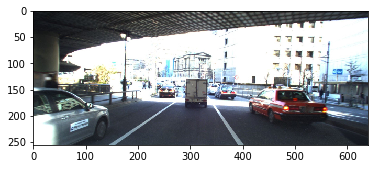

In [53]:
image_path = "./test_img/test_003.png"
image = cv2.imread(image_path)
_, ax = plt.subplots(1)
_ = ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print(image.size)

In [54]:
'''resize image with unchanged aspect ratio using padding'''
def letterbox_image(image, size):
    ih, iw, _ = image.shape
    w, h = size
    scale = min(w/iw, h/ih)
    print(scale)
    
    nw = int(iw*scale)
    nh = int(ih*scale)
    print(nw)
    print(nh)

    image = cv2.resize(image, (nw,nh), interpolation=cv2.INTER_LINEAR)
    new_image = np.ones((h,w,3), np.uint8) * 128
    h_start = (h-nh)//2
    w_start = (w-nw)//2
    new_image[h_start:h_start+nh, w_start:w_start+nw, :] = image
    return new_image

'''image preprocessing'''
def pre_process(image, model_image_size):
    image = image[...,::-1]
    image_h, image_w, _ = image.shape
 
    if model_image_size != (None, None):
        assert model_image_size[0]%32 == 0, 'Multiples of 32 required'
        assert model_image_size[1]%32 == 0, 'Multiples of 32 required'
        boxed_image = letterbox_image(image, tuple(reversed(model_image_size)))
    else:
        new_image_size = (image_w - (image_w % 32), image_h - (image_h % 32))
        boxed_image = letterbox_image(image, new_image_size)
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0) 	
    return image_data

In [55]:
image_size = image.shape[:2]
image_data = np.array(pre_process(image, (256, 640)), dtype=np.float32)
print(image_size)
print(image_data.size)  # 256*640*3

1.0
640
256
(256, 640)
491520


We create DPU kernel and task.

In [56]:
from dnndk import n2cube
n2cube.dpuOpen()
kernel = n2cube.dpuLoadKernel(KERNEL_CONV)
task = n2cube.dpuCreateTask(kernel, 0)

Now we execute the DPU task to classify an input picture.

In [57]:
input_len = n2cube.dpuGetInputTensorSize(task, CONV_INPUT_NODE)
print(input_len)
n2cube.dpuSetInputTensorInHWCFP32(task, CONV_INPUT_NODE, image_data, input_len)

#import time
# Run multiple times
#total_image = 100
#time1 = time.time()
#for i in range(total_image):
n2cube.dpuRunTask(task)

#time2 = time.time()
#fps = total_image/(time2-time1)
#print("Performance: {} FPS".format(fps))

conv_sbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE1)
print(conv_sbbox_size)
conv_out1 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE1, conv_sbbox_size)
print(conv_out1.size)
conv_out1 = np.reshape(conv_out1, (1, 32, 80, 720))

491520
Performance: 1063.060195159042 FPS
1843200
1843200


At the end, let's clean it up.

In [58]:
n2cube.dpuDestroyTask(task)
n2cube.dpuDestroyKernel(kernel)

0

In [59]:
from numpy import save
# save to npy file
save('tf_poly_yolo.conv2d_68.npy', conv_out1)

Post processing

In [13]:
import math
import numpy as np

def sigmoid(x):
  return 1 / (1 + math.exp(-x))


feats = np.load('tf_poly_yolo.conv2d_68.npy')
print(feats.shape)

with open("yolo_anchors.txt") as f:
        anchors = f.readline()
anchors = [float(x) for x in anchors.split(',')]
anchors = np.array(anchors).reshape(-1, 2)

#print(anchors)

#scan each tile 640x256 = (80x8)x(32x8)
for j in range(0,32):
        for i in range(0,80):
                perdict = feats[0,j,i,:]
                for t in range(0,8): #each anchors
                        #print(perdict)
                        box_x = (sigmoid(feats[0,j,i,t*90])   + i )/80  #my interpretation might be wrong 
                        box_y = (sigmoid(feats[0,j,i,t*90+1]) + j )/32
                        box_w = math.exp(feats[0,j,i,t*90+2])*anchors[t][0]/80  
                        box_h = math.exp(feats[0,j,i,t*90+3])*anchors[t][1]/32                  
                        box_confidence   = sigmoid(feats[0,j,i,t*90+4])
                        box_class_probs  = sigmoid(feats[0,j,i,t*90+5])
                        if ((box_confidence)>0.03):
                                print(j, i, t, box_x, box_y, box_w, box_h, box_confidence, box_class_probs)


(1, 32, 80, 720)
0 0 0 0.00625 0.015625 0.05 0.1875 0.5 0.5
0 0 1 0.00625 0.015625 0.1 0.3125 0.5 0.5
0 0 2 0.00625 0.015625 0.1 0.59375 0.5 0.5
0 0 3 0.00625 0.015625 0.175 0.96875 0.5 0.5
0 0 4 0.00625 0.015625 0.2 0.40625 0.5 0.5
0 0 5 0.00625 0.015625 0.325 1.875 0.5 0.5
0 0 6 0.00625 0.015625 0.35 0.6875 0.5 0.5
0 0 7 0.00625 0.015625 0.675 1.28125 0.5 0.5
0 1 0 0.01875 0.015625 0.05 0.1875 0.5 0.5
0 1 1 0.01875 0.015625 0.1 0.3125 0.5 0.5
0 1 2 0.01875 0.015625 0.1 0.59375 0.5 0.5
0 1 3 0.01875 0.015625 0.175 0.96875 0.5 0.5
0 1 4 0.01875 0.015625 0.2 0.40625 0.5 0.5
0 1 5 0.01875 0.015625 0.325 1.875 0.5 0.5
0 1 6 0.01875 0.015625 0.35 0.6875 0.5 0.5
0 1 7 0.01875 0.015625 0.675 1.28125 0.5 0.5
0 2 0 0.03125 0.015625 0.05 0.1875 0.5 0.5
0 2 1 0.03125 0.015625 0.1 0.3125 0.5 0.5
0 2 2 0.03125 0.015625 0.1 0.59375 0.5 0.5
0 2 3 0.03125 0.015625 0.175 0.96875 0.5 0.5
0 2 4 0.03125 0.015625 0.2 0.40625 0.5 0.5
0 2 5 0.03125 0.015625 0.325 1.875 0.5 0.5
0 2 6 0.03125 0.015625 0.35 0.

0 26 2 0.33125 0.015625 0.1 0.59375 0.5 0.5
0 26 3 0.33125 0.015625 0.175 0.96875 0.5 0.5
0 26 4 0.33125 0.015625 0.2 0.40625 0.5 0.5
0 26 5 0.33125 0.015625 0.325 1.875 0.5 0.5
0 26 6 0.33125 0.015625 0.35 0.6875 0.5 0.5
0 26 7 0.33125 0.015625 0.675 1.28125 0.5 0.5
0 27 0 0.34375 0.015625 0.05 0.1875 0.5 0.5
0 27 1 0.34375 0.015625 0.1 0.3125 0.5 0.5
0 27 2 0.34375 0.015625 0.1 0.59375 0.5 0.5
0 27 3 0.34375 0.015625 0.175 0.96875 0.5 0.5
0 27 4 0.34375 0.015625 0.2 0.40625 0.5 0.5
0 27 5 0.34375 0.015625 0.325 1.875 0.5 0.5
0 27 6 0.34375 0.015625 0.35 0.6875 0.5 0.5
0 27 7 0.34375 0.015625 0.675 1.28125 0.5 0.5
0 28 0 0.35625 0.015625 0.05 0.1875 0.5 0.5
0 28 1 0.35625 0.015625 0.1 0.3125 0.5 0.5
0 28 2 0.35625 0.015625 0.1 0.59375 0.5 0.5
0 28 3 0.35625 0.015625 0.175 0.96875 0.5 0.5
0 28 4 0.35625 0.015625 0.2 0.40625 0.5 0.5
0 28 5 0.35625 0.015625 0.325 1.875 0.5 0.5
0 28 6 0.35625 0.015625 0.35 0.6875 0.5 0.5
0 28 7 0.35625 0.015625 0.675 1.28125 0.5 0.5
0 29 0 0.36875 0.01562

0 54 0 0.68125 0.015625 0.05 0.1875 0.5 0.5
0 54 1 0.68125 0.015625 0.1 0.3125 0.5 0.5
0 54 2 0.68125 0.015625 0.1 0.59375 0.5 0.5
0 54 3 0.68125 0.015625 0.175 0.96875 0.5 0.5
0 54 4 0.68125 0.015625 0.2 0.40625 0.5 0.5
0 54 5 0.68125 0.015625 0.325 1.875 0.5 0.5
0 54 6 0.68125 0.015625 0.35 0.6875 0.5 0.5
0 54 7 0.68125 0.015625 0.675 1.28125 0.5 0.5
0 55 0 0.69375 0.015625 0.05 0.1875 0.5 0.5
0 55 1 0.69375 0.015625 0.1 0.3125 0.5 0.5
0 55 2 0.69375 0.015625 0.1 0.59375 0.5 0.5
0 55 3 0.69375 0.015625 0.175 0.96875 0.5 0.5
0 55 4 0.69375 0.015625 0.2 0.40625 0.5 0.5
0 55 5 0.69375 0.015625 0.325 1.875 0.5 0.5
0 55 6 0.69375 0.015625 0.35 0.6875 0.5 0.5
0 55 7 0.69375 0.015625 0.675 1.28125 0.5 0.5
0 56 0 0.70625 0.015625 0.05 0.1875 0.5 0.5
0 56 1 0.70625 0.015625 0.1 0.3125 0.5 0.5
0 56 2 0.70625 0.015625 0.1 0.59375 0.5 0.5
0 56 3 0.70625 0.015625 0.175 0.96875 0.5 0.5
0 56 4 0.70625 0.015625 0.2 0.40625 0.5 0.5
0 56 5 0.70625 0.015625 0.325 1.875 0.5 0.5
0 56 6 0.70625 0.015625 0

1 1 6 0.01875 0.046875 0.35 0.6875 0.5 0.5
1 1 7 0.01875 0.046875 0.675 1.28125 0.5 0.5
1 2 0 0.03125 0.046875 0.05 0.1875 0.5 0.5
1 2 1 0.03125 0.046875 0.1 0.3125 0.5 0.5
1 2 2 0.03125 0.046875 0.1 0.59375 0.5 0.5
1 2 3 0.03125 0.046875 0.175 0.96875 0.5 0.5
1 2 4 0.03125 0.046875 0.2 0.40625 0.5 0.5
1 2 5 0.03125 0.046875 0.325 1.875 0.5 0.5
1 2 6 0.03125 0.046875 0.35 0.6875 0.5 0.5
1 2 7 0.03125 0.046875 0.675 1.28125 0.5 0.5
1 3 0 0.04375 0.046875 0.05 0.1875 0.5 0.5
1 3 1 0.04375 0.046875 0.1 0.3125 0.5 0.5
1 3 2 0.04375 0.046875 0.1 0.59375 0.5 0.5
1 3 3 0.04375 0.046875 0.175 0.96875 0.5 0.5
1 3 4 0.04375 0.046875 0.2 0.40625 0.5 0.5
1 3 5 0.04375 0.046875 0.325 1.875 0.5 0.5
1 3 6 0.04375 0.046875 0.35 0.6875 0.5 0.5
1 3 7 0.04375 0.046875 0.675 1.28125 0.5 0.5
1 4 0 0.05625 0.046875 0.05 0.1875 0.5 0.5
1 4 1 0.05625 0.046875 0.1 0.3125 0.5 0.5
1 4 2 0.05625 0.046875 0.1 0.59375 0.5 0.5
1 4 3 0.05625 0.046875 0.175 0.96875 0.5 0.5
1 4 4 0.05625 0.046875 0.2 0.40625 0.5 0.5
1 

1 29 4 0.36875 0.046875 0.2 0.40625 0.5 0.5
1 29 5 0.36875 0.046875 0.325 1.875 0.5 0.5
1 29 6 0.36875 0.046875 0.35 0.6875 0.5 0.5
1 29 7 0.36875 0.046875 0.675 1.28125 0.5 0.5
1 30 0 0.38125 0.046875 0.05 0.1875 0.5 0.5
1 30 1 0.38125 0.046875 0.1 0.3125 0.5 0.5
1 30 2 0.38125 0.046875 0.1 0.59375 0.5 0.5
1 30 3 0.38125 0.046875 0.175 0.96875 0.5 0.5
1 30 4 0.38125 0.046875 0.2 0.40625 0.5 0.5
1 30 5 0.38125 0.046875 0.325 1.875 0.5 0.5
1 30 6 0.38125 0.046875 0.35 0.6875 0.5 0.5
1 30 7 0.38125 0.046875 0.675 1.28125 0.5 0.5
1 31 0 0.39375 0.046875 0.05 0.1875 0.5 0.5
1 31 1 0.39375 0.046875 0.1 0.3125 0.5 0.5
1 31 2 0.39375 0.046875 0.1 0.59375 0.5 0.5
1 31 3 0.39375 0.046875 0.175 0.96875 0.5 0.5
1 31 4 0.39375 0.046875 0.2 0.40625 0.5 0.5
1 31 5 0.39375 0.046875 0.325 1.875 0.5 0.5
1 31 6 0.39375 0.046875 0.35 0.6875 0.5 0.5
1 31 7 0.39375 0.046875 0.675 1.28125 0.5 0.5
1 32 0 0.40625 0.046875 0.05 0.1875 0.5 0.5
1 32 1 0.40625 0.046875 0.1 0.3125 0.5 0.5
1 32 2 0.40625 0.046875 0

1 57 2 0.71875 0.046875 0.1 0.59375 0.5 0.5
1 57 3 0.71875 0.046875 0.175 0.96875 0.5 0.5
1 57 4 0.71875 0.046875 0.2 0.40625 0.5 0.5
1 57 5 0.71875 0.046875 0.325 1.875 0.5 0.5
1 57 6 0.71875 0.046875 0.35 0.6875 0.5 0.5
1 57 7 0.71875 0.046875 0.675 1.28125 0.5 0.5
1 58 0 0.73125 0.046875 0.05 0.1875 0.5 0.5
1 58 1 0.73125 0.046875 0.1 0.3125 0.5 0.5
1 58 2 0.73125 0.046875 0.1 0.59375 0.5 0.5
1 58 3 0.73125 0.046875 0.175 0.96875 0.5 0.5
1 58 4 0.73125 0.046875 0.2 0.40625 0.5 0.5
1 58 5 0.73125 0.046875 0.325 1.875 0.5 0.5
1 58 6 0.73125 0.046875 0.35 0.6875 0.5 0.5
1 58 7 0.73125 0.046875 0.675 1.28125 0.5 0.5
1 59 0 0.74375 0.046875 0.05 0.1875 0.5 0.5
1 59 1 0.74375 0.046875 0.1 0.3125 0.5 0.5
1 59 2 0.74375 0.046875 0.1 0.59375 0.5 0.5
1 59 3 0.74375 0.046875 0.175 0.96875 0.5 0.5
1 59 4 0.74375 0.046875 0.2 0.40625 0.5 0.5
1 59 5 0.74375 0.046875 0.325 1.875 0.5 0.5
1 59 6 0.74375 0.046875 0.35 0.6875 0.5 0.5
1 59 7 0.74375 0.046875 0.675 1.28125 0.5 0.5
1 60 0 0.75625 0.04687

2 5 0 0.06875 0.078125 0.05 0.1875 0.5 0.5
2 5 1 0.06875 0.078125 0.1 0.3125 0.5 0.5
2 5 2 0.06875 0.078125 0.1 0.59375 0.5 0.5
2 5 3 0.06875 0.078125 0.175 0.96875 0.5 0.5
2 5 4 0.06875 0.078125 0.2 0.40625 0.5 0.5
2 5 5 0.06875 0.078125 0.325 1.875 0.5 0.5
2 5 6 0.06875 0.078125 0.35 0.6875 0.5 0.5
2 5 7 0.06875 0.078125 0.675 1.28125 0.5 0.5
2 6 0 0.08125 0.078125 0.05 0.1875 0.5 0.5
2 6 1 0.08125 0.078125 0.1 0.3125 0.5 0.5
2 6 2 0.08125 0.078125 0.1 0.59375 0.5 0.5
2 6 3 0.08125 0.078125 0.175 0.96875 0.5 0.5
2 6 4 0.08125 0.078125 0.2 0.40625 0.5 0.5
2 6 5 0.08125 0.078125 0.325 1.875 0.5 0.5
2 6 6 0.08125 0.078125 0.35 0.6875 0.5 0.5
2 6 7 0.08125 0.078125 0.675 1.28125 0.5 0.5
2 7 0 0.09375 0.078125 0.05 0.1875 0.5 0.5
2 7 1 0.09375 0.078125 0.1 0.3125 0.5 0.5
2 7 2 0.09375 0.078125 0.1 0.59375 0.5 0.5
2 7 3 0.09375 0.078125 0.175 0.96875 0.5 0.5
2 7 4 0.09375 0.078125 0.2 0.40625 0.5 0.5
2 7 5 0.09375 0.078125 0.325 1.875 0.5 0.5
2 7 6 0.09375 0.078125 0.35 0.6875 0.5 0.5
2 7 

2 32 6 0.40625 0.078125 0.35 0.6875 0.5 0.5
2 32 7 0.40625 0.078125 0.675 1.28125 0.5 0.5
2 33 0 0.41875 0.078125 0.05 0.1875 0.5 0.5
2 33 1 0.41875 0.078125 0.1 0.3125 0.5 0.5
2 33 2 0.41875 0.078125 0.1 0.59375 0.5 0.5
2 33 3 0.41875 0.078125 0.175 0.96875 0.5 0.5
2 33 4 0.41875 0.078125 0.2 0.40625 0.5 0.5
2 33 5 0.41875 0.078125 0.325 1.875 0.5 0.5
2 33 6 0.41875 0.078125 0.35 0.6875 0.5 0.5
2 33 7 0.41875 0.078125 0.675 1.28125 0.5 0.5
2 34 0 0.43125 0.078125 0.05 0.1875 0.5 0.5
2 34 1 0.43125 0.078125 0.1 0.3125 0.5 0.5
2 34 2 0.43125 0.078125 0.1 0.59375 0.5 0.5
2 34 3 0.43125 0.078125 0.175 0.96875 0.5 0.5
2 34 4 0.43125 0.078125 0.2 0.40625 0.5 0.5
2 34 5 0.43125 0.078125 0.325 1.875 0.5 0.5
2 34 6 0.43125 0.078125 0.35 0.6875 0.5 0.5
2 34 7 0.43125 0.078125 0.675 1.28125 0.5 0.5
2 35 0 0.44375 0.078125 0.05 0.1875 0.5 0.5
2 35 1 0.44375 0.078125 0.1 0.3125 0.5 0.5
2 35 2 0.44375 0.078125 0.1 0.59375 0.5 0.5
2 35 3 0.44375 0.078125 0.175 0.96875 0.5 0.5
2 35 4 0.44375 0.078125

2 60 4 0.75625 0.078125 0.2 0.40625 0.5 0.5
2 60 5 0.75625 0.078125 0.325 1.875 0.5 0.5
2 60 6 0.75625 0.078125 0.35 0.6875 0.5 0.5
2 60 7 0.75625 0.078125 0.675 1.28125 0.5 0.5
2 61 0 0.76875 0.078125 0.05 0.1875 0.5 0.5
2 61 1 0.76875 0.078125 0.1 0.3125 0.5 0.5
2 61 2 0.76875 0.078125 0.1 0.59375 0.5 0.5
2 61 3 0.76875 0.078125 0.175 0.96875 0.5 0.5
2 61 4 0.76875 0.078125 0.2 0.40625 0.5 0.5
2 61 5 0.76875 0.078125 0.325 1.875 0.5 0.5
2 61 6 0.76875 0.078125 0.35 0.6875 0.5 0.5
2 61 7 0.76875 0.078125 0.675 1.28125 0.5 0.5
2 62 0 0.78125 0.078125 0.05 0.1875 0.5 0.5
2 62 1 0.78125 0.078125 0.1 0.3125 0.5 0.5
2 62 2 0.78125 0.078125 0.1 0.59375 0.5 0.5
2 62 3 0.78125 0.078125 0.175 0.96875 0.5 0.5
2 62 4 0.78125 0.078125 0.2 0.40625 0.5 0.5
2 62 5 0.78125 0.078125 0.325 1.875 0.5 0.5
2 62 6 0.78125 0.078125 0.35 0.6875 0.5 0.5
2 62 7 0.78125 0.078125 0.675 1.28125 0.5 0.5
2 63 0 0.79375 0.078125 0.05 0.1875 0.5 0.5
2 63 1 0.79375 0.078125 0.1 0.3125 0.5 0.5
2 63 2 0.79375 0.078125 0

3 8 2 0.10625 0.109375 0.1 0.59375 0.5 0.5
3 8 3 0.10625 0.109375 0.175 0.96875 0.5 0.5
3 8 4 0.10625 0.109375 0.2 0.40625 0.5 0.5
3 8 5 0.10625 0.109375 0.325 1.875 0.5 0.5
3 8 6 0.10625 0.109375 0.35 0.6875 0.5 0.5
3 8 7 0.10625 0.109375 0.675 1.28125 0.5 0.5
3 9 0 0.11875 0.109375 0.05 0.1875 0.5 0.5
3 9 1 0.11875 0.109375 0.1 0.3125 0.5 0.5
3 9 2 0.11875 0.109375 0.1 0.59375 0.5 0.5
3 9 3 0.11875 0.109375 0.175 0.96875 0.5 0.5
3 9 4 0.11875 0.109375 0.2 0.40625 0.5 0.5
3 9 5 0.11875 0.109375 0.325 1.875 0.5 0.5
3 9 6 0.11875 0.109375 0.35 0.6875 0.5 0.5
3 9 7 0.11875 0.109375 0.675 1.28125 0.5 0.5
3 10 0 0.13125 0.109375 0.05 0.1875 0.5 0.5
3 10 1 0.13125 0.109375 0.1 0.3125 0.5 0.5
3 10 2 0.13125 0.109375 0.1 0.59375 0.5 0.5
3 10 3 0.13125 0.109375 0.175 0.96875 0.5 0.5
3 10 4 0.13125 0.109375 0.2 0.40625 0.5 0.5
3 10 5 0.13125 0.109375 0.325 1.875 0.5 0.5
3 10 6 0.13125 0.109375 0.35 0.6875 0.5 0.5
3 10 7 0.13125 0.109375 0.675 1.28125 0.5 0.5
3 11 0 0.14375 0.109375 0.05 0.1875 

3 36 0 0.45625 0.109375 0.05 0.1875 0.5 0.5
3 36 1 0.45625 0.109375 0.1 0.3125 0.5 0.5
3 36 2 0.45625 0.109375 0.1 0.59375 0.5 0.5
3 36 3 0.45625 0.109375 0.175 0.96875 0.5 0.5
3 36 4 0.45625 0.109375 0.2 0.40625 0.5 0.5
3 36 5 0.45625 0.109375 0.325 1.875 0.5 0.5
3 36 6 0.45625 0.109375 0.35 0.6875 0.5 0.5
3 36 7 0.45625 0.109375 0.675 1.28125 0.5 0.5
3 37 0 0.46875 0.109375 0.05 0.1875 0.5 0.5
3 37 1 0.46875 0.109375 0.1 0.3125 0.5 0.5
3 37 2 0.46875 0.109375 0.1 0.59375 0.5 0.5
3 37 3 0.46875 0.109375 0.175 0.96875 0.5 0.5
3 37 4 0.46875 0.109375 0.2 0.40625 0.5 0.5
3 37 5 0.46875 0.109375 0.325 1.875 0.5 0.5
3 37 6 0.46875 0.109375 0.35 0.6875 0.5 0.5
3 37 7 0.46875 0.109375 0.675 1.28125 0.5 0.5
3 38 0 0.48125 0.109375 0.05 0.1875 0.5 0.5
3 38 1 0.48125 0.109375 0.1 0.3125 0.5 0.5
3 38 2 0.48125 0.109375 0.1 0.59375 0.5 0.5
3 38 3 0.48125 0.109375 0.175 0.96875 0.5 0.5
3 38 4 0.48125 0.109375 0.2 0.40625 0.5 0.5
3 38 5 0.48125 0.109375 0.325 1.875 0.5 0.5
3 38 6 0.48125 0.109375 0

3 63 6 0.79375 0.109375 0.35 0.6875 0.5 0.5
3 63 7 0.79375 0.109375 0.675 1.28125 0.5 0.5
3 64 0 0.80625 0.109375 0.05 0.1875 0.5 0.5
3 64 1 0.80625 0.109375 0.1 0.3125 0.5 0.5
3 64 2 0.80625 0.109375 0.1 0.59375 0.5 0.5
3 64 3 0.80625 0.109375 0.175 0.96875 0.5 0.5
3 64 4 0.80625 0.109375 0.2 0.40625 0.5 0.5
3 64 5 0.80625 0.109375 0.325 1.875 0.5 0.5
3 64 6 0.80625 0.109375 0.35 0.6875 0.5 0.5
3 64 7 0.80625 0.109375 0.675 1.28125 0.5 0.5
3 65 0 0.81875 0.109375 0.05 0.1875 0.5 0.5
3 65 1 0.81875 0.109375 0.1 0.3125 0.5 0.5
3 65 2 0.81875 0.109375 0.1 0.59375 0.5 0.5
3 65 3 0.81875 0.109375 0.175 0.96875 0.5 0.5
3 65 4 0.81875 0.109375 0.2 0.40625 0.5 0.5
3 65 5 0.81875 0.109375 0.325 1.875 0.5 0.5
3 65 6 0.81875 0.109375 0.35 0.6875 0.5 0.5
3 65 7 0.81875 0.109375 0.675 1.28125 0.5 0.5
3 66 0 0.83125 0.109375 0.05 0.1875 0.5 0.5
3 66 1 0.83125 0.109375 0.1 0.3125 0.5 0.5
3 66 2 0.83125 0.109375 0.1 0.59375 0.5 0.5
3 66 3 0.83125 0.109375 0.175 0.96875 0.5 0.5
3 66 4 0.83125 0.109375

4 11 4 0.14375 0.140625 0.2 0.40625 0.5 0.5
4 11 5 0.14375 0.140625 0.325 1.875 0.5 0.5
4 11 6 0.14375 0.140625 0.35 0.6875 0.5 0.5
4 11 7 0.14375 0.140625 0.675 1.28125 0.5 0.5
4 12 0 0.15625 0.140625 0.05 0.1875 0.5 0.5
4 12 1 0.15625 0.140625 0.1 0.3125 0.5 0.5
4 12 2 0.15625 0.140625 0.1 0.59375 0.5 0.5
4 12 3 0.15625 0.140625 0.175 0.96875 0.5 0.5
4 12 4 0.15625 0.140625 0.2 0.40625 0.5 0.5
4 12 5 0.15625 0.140625 0.325 1.875 0.5 0.5
4 12 6 0.15625 0.140625 0.35 0.6875 0.5 0.5
4 12 7 0.15625 0.140625 0.675 1.28125 0.5 0.5
4 13 0 0.16875 0.140625 0.05 0.1875 0.5 0.5
4 13 1 0.16875 0.140625 0.1 0.3125 0.5 0.5
4 13 2 0.16875 0.140625 0.1 0.59375 0.5 0.5
4 13 3 0.16875 0.140625 0.175 0.96875 0.5 0.5
4 13 4 0.16875 0.140625 0.2 0.40625 0.5 0.5
4 13 5 0.16875 0.140625 0.325 1.875 0.5 0.5
4 13 6 0.16875 0.140625 0.35 0.6875 0.5 0.5
4 13 7 0.16875 0.140625 0.675 1.28125 0.5 0.5
4 14 0 0.18125 0.140625 0.05 0.1875 0.5 0.5
4 14 1 0.18125 0.140625 0.1 0.3125 0.5 0.5
4 14 2 0.18125 0.140625 0

4 39 2 0.49375 0.140625 0.1 0.59375 0.5 0.5
4 39 3 0.49375 0.140625 0.175 0.96875 0.5 0.5
4 39 4 0.49375 0.140625 0.2 0.40625 0.5 0.5
4 39 5 0.49375 0.140625 0.325 1.875 0.5 0.5
4 39 6 0.49375 0.140625 0.35 0.6875 0.5 0.5
4 39 7 0.49375 0.140625 0.675 1.28125 0.5 0.5
4 40 0 0.50625 0.140625 0.05 0.1875 0.5 0.5
4 40 1 0.50625 0.140625 0.1 0.3125 0.5 0.5
4 40 2 0.50625 0.140625 0.1 0.59375 0.5 0.5
4 40 3 0.50625 0.140625 0.175 0.96875 0.5 0.5
4 40 4 0.50625 0.140625 0.2 0.40625 0.5 0.5
4 40 5 0.50625 0.140625 0.325 1.875 0.5 0.5
4 40 6 0.50625 0.140625 0.35 0.6875 0.5 0.5
4 40 7 0.50625 0.140625 0.675 1.28125 0.5 0.5
4 41 0 0.51875 0.140625 0.05 0.1875 0.5 0.5
4 41 1 0.51875 0.140625 0.1 0.3125 0.5 0.5
4 41 2 0.51875 0.140625 0.1 0.59375 0.5 0.5
4 41 3 0.51875 0.140625 0.175 0.96875 0.5 0.5
4 41 4 0.51875 0.140625 0.2 0.40625 0.5 0.5
4 41 5 0.51875 0.140625 0.325 1.875 0.5 0.5
4 41 6 0.51875 0.140625 0.35 0.6875 0.5 0.5
4 41 7 0.51875 0.140625 0.675 1.28125 0.5 0.5
4 42 0 0.53125 0.14062

4 67 0 0.84375 0.140625 0.05 0.1875 0.5 0.5
4 67 1 0.84375 0.140625 0.1 0.3125 0.5 0.5
4 67 2 0.84375 0.140625 0.1 0.59375 0.5 0.5
4 67 3 0.84375 0.140625 0.175 0.96875 0.5 0.5
4 67 4 0.84375 0.140625 0.2 0.40625 0.5 0.5
4 67 5 0.84375 0.140625 0.325 1.875 0.5 0.5
4 67 6 0.84375 0.140625 0.35 0.6875 0.5 0.5
4 67 7 0.84375 0.140625 0.675 1.28125 0.5 0.5
4 68 0 0.85625 0.140625 0.05 0.1875 0.5 0.5
4 68 1 0.85625 0.140625 0.1 0.3125 0.5 0.5
4 68 2 0.85625 0.140625 0.1 0.59375 0.5 0.5
4 68 3 0.85625 0.140625 0.175 0.96875 0.5 0.5
4 68 4 0.85625 0.140625 0.2 0.40625 0.5 0.5
4 68 5 0.85625 0.140625 0.325 1.875 0.5 0.5
4 68 6 0.85625 0.140625 0.35 0.6875 0.5 0.5
4 68 7 0.85625 0.140625 0.675 1.28125 0.5 0.5
4 69 0 0.86875 0.140625 0.05 0.1875 0.5 0.5
4 69 1 0.86875 0.140625 0.1 0.3125 0.5 0.5
4 69 2 0.86875 0.140625 0.1 0.59375 0.5 0.5
4 69 3 0.86875 0.140625 0.175 0.96875 0.5 0.5
4 69 4 0.86875 0.140625 0.2 0.40625 0.5 0.5
4 69 5 0.86875 0.140625 0.325 1.875 0.5 0.5
4 69 6 0.86875 0.140625 0

5 14 6 0.18125 0.171875 0.35 0.6875 0.5 0.5
5 14 7 0.18125 0.171875 0.675 1.28125 0.5 0.5
5 15 0 0.19375 0.171875 0.05 0.1875 0.5 0.5
5 15 1 0.19375 0.171875 0.1 0.3125 0.5 0.5
5 15 2 0.19375 0.171875 0.1 0.59375 0.5 0.5
5 15 3 0.19375 0.171875 0.175 0.96875 0.5 0.5
5 15 4 0.19375 0.171875 0.2 0.40625 0.5 0.5
5 15 5 0.19375 0.171875 0.325 1.875 0.5 0.5
5 15 6 0.19375 0.171875 0.35 0.6875 0.5 0.5
5 15 7 0.19375 0.171875 0.675 1.28125 0.5 0.5
5 16 0 0.20625 0.171875 0.05 0.1875 0.5 0.5
5 16 1 0.20625 0.171875 0.1 0.3125 0.5 0.5
5 16 2 0.20625 0.171875 0.1 0.59375 0.5 0.5
5 16 3 0.20625 0.171875 0.175 0.96875 0.5 0.5
5 16 4 0.20625 0.171875 0.2 0.40625 0.5 0.5
5 16 5 0.20625 0.171875 0.325 1.875 0.5 0.5
5 16 6 0.20625 0.171875 0.35 0.6875 0.5 0.5
5 16 7 0.20625 0.171875 0.675 1.28125 0.5 0.5
5 17 0 0.21875 0.171875 0.05 0.1875 0.5 0.5
5 17 1 0.21875 0.171875 0.1 0.3125 0.5 0.5
5 17 2 0.21875 0.171875 0.1 0.59375 0.5 0.5
5 17 3 0.21875 0.171875 0.175 0.96875 0.5 0.5
5 17 4 0.21875 0.171875

5 42 4 0.53125 0.171875 0.2 0.40625 0.5 0.5
5 42 5 0.53125 0.171875 0.325 1.875 0.5 0.5
5 42 6 0.53125 0.171875 0.35 0.6875 0.5 0.5
5 42 7 0.53125 0.171875 0.675 1.28125 0.5 0.5
5 43 0 0.54375 0.171875 0.05 0.1875 0.5 0.5
5 43 1 0.54375 0.171875 0.1 0.3125 0.5 0.5
5 43 2 0.54375 0.171875 0.1 0.59375 0.5 0.5
5 43 3 0.54375 0.171875 0.175 0.96875 0.5 0.5
5 43 4 0.54375 0.171875 0.2 0.40625 0.5 0.5
5 43 5 0.54375 0.171875 0.325 1.875 0.5 0.5
5 43 6 0.54375 0.171875 0.35 0.6875 0.5 0.5
5 43 7 0.54375 0.171875 0.675 1.28125 0.5 0.5
5 44 0 0.55625 0.171875 0.05 0.1875 0.5 0.5
5 44 1 0.55625 0.171875 0.1 0.3125 0.5 0.5
5 44 2 0.55625 0.171875 0.1 0.59375 0.5 0.5
5 44 3 0.55625 0.171875 0.175 0.96875 0.5 0.5
5 44 4 0.55625 0.171875 0.2 0.40625 0.5 0.5
5 44 5 0.55625 0.171875 0.325 1.875 0.5 0.5
5 44 6 0.55625 0.171875 0.35 0.6875 0.5 0.5
5 44 7 0.55625 0.171875 0.675 1.28125 0.5 0.5
5 45 0 0.56875 0.171875 0.05 0.1875 0.5 0.5
5 45 1 0.56875 0.171875 0.1 0.3125 0.5 0.5
5 45 2 0.56875 0.171875 0

5 70 2 0.88125 0.171875 0.1 0.59375 0.5 0.5
5 70 3 0.88125 0.171875 0.175 0.96875 0.5 0.5
5 70 4 0.88125 0.171875 0.2 0.40625 0.5 0.5
5 70 5 0.88125 0.171875 0.325 1.875 0.5 0.5
5 70 6 0.88125 0.171875 0.35 0.6875 0.5 0.5
5 70 7 0.88125 0.171875 0.675 1.28125 0.5 0.5
5 71 0 0.89375 0.171875 0.05 0.1875 0.5 0.5
5 71 1 0.89375 0.171875 0.1 0.3125 0.5 0.5
5 71 2 0.89375 0.171875 0.1 0.59375 0.5 0.5
5 71 3 0.89375 0.171875 0.175 0.96875 0.5 0.5
5 71 4 0.89375 0.171875 0.2 0.40625 0.5 0.5
5 71 5 0.89375 0.171875 0.325 1.875 0.5 0.5
5 71 6 0.89375 0.171875 0.35 0.6875 0.5 0.5
5 71 7 0.89375 0.171875 0.675 1.28125 0.5 0.5
5 72 0 0.90625 0.171875 0.05 0.1875 0.5 0.5
5 72 1 0.90625 0.171875 0.1 0.3125 0.5 0.5
5 72 2 0.90625 0.171875 0.1 0.59375 0.5 0.5
5 72 3 0.90625 0.171875 0.175 0.96875 0.5 0.5
5 72 4 0.90625 0.171875 0.2 0.40625 0.5 0.5
5 72 5 0.90625 0.171875 0.325 1.875 0.5 0.5
5 72 6 0.90625 0.171875 0.35 0.6875 0.5 0.5
5 72 7 0.90625 0.171875 0.675 1.28125 0.5 0.5
5 73 0 0.91875 0.17187

6 18 0 0.23125 0.203125 0.05 0.1875 0.5 0.5
6 18 1 0.23125 0.203125 0.1 0.3125 0.5 0.5
6 18 2 0.23125 0.203125 0.1 0.59375 0.5 0.5
6 18 3 0.23125 0.203125 0.175 0.96875 0.5 0.5
6 18 4 0.23125 0.203125 0.2 0.40625 0.5 0.5
6 18 5 0.23125 0.203125 0.325 1.875 0.5 0.5
6 18 6 0.23125 0.203125 0.35 0.6875 0.5 0.5
6 18 7 0.23125 0.203125 0.675 1.28125 0.5 0.5
6 19 0 0.24375 0.203125 0.05 0.1875 0.5 0.5
6 19 1 0.24375 0.203125 0.1 0.3125 0.5 0.5
6 19 2 0.24375 0.203125 0.1 0.59375 0.5 0.5
6 19 3 0.24375 0.203125 0.175 0.96875 0.5 0.5
6 19 4 0.24375 0.203125 0.2 0.40625 0.5 0.5
6 19 5 0.24375 0.203125 0.325 1.875 0.5 0.5
6 19 6 0.24375 0.203125 0.35 0.6875 0.5 0.5
6 19 7 0.24375 0.203125 0.675 1.28125 0.5 0.5
6 20 0 0.25625 0.203125 0.05 0.1875 0.5 0.5
6 20 1 0.25625 0.203125 0.1 0.3125 0.5 0.5
6 20 2 0.25625 0.203125 0.1 0.59375 0.5 0.5
6 20 3 0.25625 0.203125 0.175 0.96875 0.5 0.5
6 20 4 0.25625 0.203125 0.2 0.40625 0.5 0.5
6 20 5 0.25625 0.203125 0.325 1.875 0.5 0.5
6 20 6 0.25625 0.203125 0

6 45 6 0.56875 0.203125 0.35 0.6875 0.5 0.5
6 45 7 0.56875 0.203125 0.675 1.28125 0.5 0.5
6 46 0 0.58125 0.203125 0.05 0.1875 0.5 0.5
6 46 1 0.58125 0.203125 0.1 0.3125 0.5 0.5
6 46 2 0.58125 0.203125 0.1 0.59375 0.5 0.5
6 46 3 0.58125 0.203125 0.175 0.96875 0.5 0.5
6 46 4 0.58125 0.203125 0.2 0.40625 0.5 0.5
6 46 5 0.58125 0.203125 0.325 1.875 0.5 0.5
6 46 6 0.58125 0.203125 0.35 0.6875 0.5 0.5
6 46 7 0.58125 0.203125 0.675 1.28125 0.5 0.5
6 47 0 0.59375 0.203125 0.05 0.1875 0.5 0.5
6 47 1 0.59375 0.203125 0.1 0.3125 0.5 0.5
6 47 2 0.59375 0.203125 0.1 0.59375 0.5 0.5
6 47 3 0.59375 0.203125 0.175 0.96875 0.5 0.5
6 47 4 0.59375 0.203125 0.2 0.40625 0.5 0.5
6 47 5 0.59375 0.203125 0.325 1.875 0.5 0.5
6 47 6 0.59375 0.203125 0.35 0.6875 0.5 0.5
6 47 7 0.59375 0.203125 0.675 1.28125 0.5 0.5
6 48 0 0.60625 0.203125 0.05 0.1875 0.5 0.5
6 48 1 0.60625 0.203125 0.1 0.3125 0.5 0.5
6 48 2 0.60625 0.203125 0.1 0.59375 0.5 0.5
6 48 3 0.60625 0.203125 0.175 0.96875 0.5 0.5
6 48 4 0.60625 0.203125

6 73 4 0.91875 0.203125 0.2 0.40625 0.5 0.5
6 73 5 0.91875 0.203125 0.325 1.875 0.5 0.5
6 73 6 0.91875 0.203125 0.35 0.6875 0.5 0.5
6 73 7 0.91875 0.203125 0.675 1.28125 0.5 0.5
6 74 0 0.93125 0.203125 0.05 0.1875 0.5 0.5
6 74 1 0.93125 0.203125 0.1 0.3125 0.5 0.5
6 74 2 0.93125 0.203125 0.1 0.59375 0.5 0.5
6 74 3 0.93125 0.203125 0.175 0.96875 0.5 0.5
6 74 4 0.93125 0.203125 0.2 0.40625 0.5 0.5
6 74 5 0.93125 0.203125 0.325 1.875 0.5 0.5
6 74 6 0.93125 0.203125 0.35 0.6875 0.5 0.5
6 74 7 0.93125 0.203125 0.675 1.28125 0.5 0.5
6 75 0 0.94375 0.203125 0.05 0.1875 0.5 0.5
6 75 1 0.94375 0.203125 0.1 0.3125 0.5 0.5
6 75 2 0.94375 0.203125 0.1 0.59375 0.5 0.5
6 75 3 0.94375 0.203125 0.175 0.96875 0.5 0.5
6 75 4 0.94375 0.203125 0.2 0.40625 0.5 0.5
6 75 5 0.94375 0.203125 0.325 1.875 0.5 0.5
6 75 6 0.94375 0.203125 0.35 0.6875 0.5 0.5
6 75 7 0.94375 0.203125 0.675 1.28125 0.5 0.5
6 76 0 0.95625 0.203125 0.05 0.1875 0.5 0.5
6 76 1 0.95625 0.203125 0.1 0.3125 0.5 0.5
6 76 2 0.95625 0.203125 0

7 21 2 0.26875 0.234375 0.1 0.59375 0.5 0.5
7 21 3 0.26875 0.234375 0.175 0.96875 0.5 0.5
7 21 4 0.26875 0.234375 0.2 0.40625 0.5 0.5
7 21 5 0.26875 0.234375 0.325 1.875 0.5 0.5
7 21 6 0.26875 0.234375 0.35 0.6875 0.5 0.5
7 21 7 0.26875 0.234375 0.675 1.28125 0.5 0.5
7 22 0 0.28125 0.234375 0.05 0.1875 0.5 0.5
7 22 1 0.28125 0.234375 0.1 0.3125 0.5 0.5
7 22 2 0.28125 0.234375 0.1 0.59375 0.5 0.5
7 22 3 0.28125 0.234375 0.175 0.96875 0.5 0.5
7 22 4 0.28125 0.234375 0.2 0.40625 0.5 0.5
7 22 5 0.28125 0.234375 0.325 1.875 0.5 0.5
7 22 6 0.28125 0.234375 0.35 0.6875 0.5 0.5
7 22 7 0.28125 0.234375 0.675 1.28125 0.5 0.5
7 23 0 0.29375 0.234375 0.05 0.1875 0.5 0.5
7 23 1 0.29375 0.234375 0.1 0.3125 0.5 0.5
7 23 2 0.29375 0.234375 0.1 0.59375 0.5 0.5
7 23 3 0.29375 0.234375 0.175 0.96875 0.5 0.5
7 23 4 0.29375 0.234375 0.2 0.40625 0.5 0.5
7 23 5 0.29375 0.234375 0.325 1.875 0.5 0.5
7 23 6 0.29375 0.234375 0.35 0.6875 0.5 0.5
7 23 7 0.29375 0.234375 0.675 1.28125 0.5 0.5
7 24 0 0.30625 0.23437

7 49 0 0.61875 0.234375 0.05 0.1875 0.5 0.5
7 49 1 0.61875 0.234375 0.1 0.3125 0.5 0.5
7 49 2 0.61875 0.234375 0.1 0.59375 0.5 0.5
7 49 3 0.61875 0.234375 0.175 0.96875 0.5 0.5
7 49 4 0.61875 0.234375 0.2 0.40625 0.5 0.5
7 49 5 0.61875 0.234375 0.325 1.875 0.5 0.5
7 49 6 0.61875 0.234375 0.35 0.6875 0.5 0.5
7 49 7 0.61875 0.234375 0.675 1.28125 0.5 0.5
7 50 0 0.63125 0.234375 0.05 0.1875 0.5 0.5
7 50 1 0.63125 0.234375 0.1 0.3125 0.5 0.5
7 50 2 0.63125 0.234375 0.1 0.59375 0.5 0.5
7 50 3 0.63125 0.234375 0.175 0.96875 0.5 0.5
7 50 4 0.63125 0.234375 0.2 0.40625 0.5 0.5
7 50 5 0.63125 0.234375 0.325 1.875 0.5 0.5
7 50 6 0.63125 0.234375 0.35 0.6875 0.5 0.5
7 50 7 0.63125 0.234375 0.675 1.28125 0.5 0.5
7 51 0 0.64375 0.234375 0.05 0.1875 0.5 0.5
7 51 1 0.64375 0.234375 0.1 0.3125 0.5 0.5
7 51 2 0.64375 0.234375 0.1 0.59375 0.5 0.5
7 51 3 0.64375 0.234375 0.175 0.96875 0.5 0.5
7 51 4 0.64375 0.234375 0.2 0.40625 0.5 0.5
7 51 5 0.64375 0.234375 0.325 1.875 0.5 0.5
7 51 6 0.64375 0.234375 0

7 76 6 0.95625 0.234375 0.35 0.6875 0.5 0.5
7 76 7 0.95625 0.234375 0.675 1.28125 0.5 0.5
7 77 0 0.96875 0.234375 0.05 0.1875 0.5 0.5
7 77 1 0.96875 0.234375 0.1 0.3125 0.5 0.5
7 77 2 0.96875 0.234375 0.1 0.59375 0.5 0.5
7 77 3 0.96875 0.234375 0.175 0.96875 0.5 0.5
7 77 4 0.96875 0.234375 0.2 0.40625 0.5 0.5
7 77 5 0.96875 0.234375 0.325 1.875 0.5 0.5
7 77 6 0.96875 0.234375 0.35 0.6875 0.5 0.5
7 77 7 0.96875 0.234375 0.675 1.28125 0.5 0.5
7 78 0 0.98125 0.234375 0.05 0.1875 0.5 0.5
7 78 1 0.98125 0.234375 0.1 0.3125 0.5 0.5
7 78 2 0.98125 0.234375 0.1 0.59375 0.5 0.5
7 78 3 0.98125 0.234375 0.175 0.96875 0.5 0.5
7 78 4 0.98125 0.234375 0.2 0.40625 0.5 0.5
7 78 5 0.98125 0.234375 0.325 1.875 0.5 0.5
7 78 6 0.98125 0.234375 0.35 0.6875 0.5 0.5
7 78 7 0.98125 0.234375 0.675 1.28125 0.5 0.5
7 79 0 0.99375 0.234375 0.05 0.1875 0.5 0.5
7 79 1 0.99375 0.234375 0.1 0.3125 0.5 0.5
7 79 2 0.99375 0.234375 0.1 0.59375 0.5 0.5
7 79 3 0.99375 0.234375 0.175 0.96875 0.5 0.5
7 79 4 0.99375 0.234375

8 24 4 0.30625 0.265625 0.2 0.40625 0.5 0.5
8 24 5 0.30625 0.265625 0.325 1.875 0.5 0.5
8 24 6 0.30625 0.265625 0.35 0.6875 0.5 0.5
8 24 7 0.30625 0.265625 0.675 1.28125 0.5 0.5
8 25 0 0.31875 0.265625 0.05 0.1875 0.5 0.5
8 25 1 0.31875 0.265625 0.1 0.3125 0.5 0.5
8 25 2 0.31875 0.265625 0.1 0.59375 0.5 0.5
8 25 3 0.31875 0.265625 0.175 0.96875 0.5 0.5
8 25 4 0.31875 0.265625 0.2 0.40625 0.5 0.5
8 25 5 0.31875 0.265625 0.325 1.875 0.5 0.5
8 25 6 0.31875 0.265625 0.35 0.6875 0.5 0.5
8 25 7 0.31875 0.265625 0.675 1.28125 0.5 0.5
8 26 0 0.33125 0.265625 0.05 0.1875 0.5 0.5
8 26 1 0.33125 0.265625 0.1 0.3125 0.5 0.5
8 26 2 0.33125 0.265625 0.1 0.59375 0.5 0.5
8 26 3 0.33125 0.265625 0.175 0.96875 0.5 0.5
8 26 4 0.33125 0.265625 0.2 0.40625 0.5 0.5
8 26 5 0.33125 0.265625 0.325 1.875 0.5 0.5
8 26 6 0.33125 0.265625 0.35 0.6875 0.5 0.5
8 26 7 0.33125 0.265625 0.675 1.28125 0.5 0.5
8 27 0 0.34375 0.265625 0.05 0.1875 0.5 0.5
8 27 1 0.34375 0.265625 0.1 0.3125 0.5 0.5
8 27 2 0.34375 0.265625 0

8 52 2 0.65625 0.265625 0.1 0.59375 0.5 0.5
8 52 3 0.65625 0.265625 0.175 0.96875 0.5 0.5
8 52 4 0.65625 0.265625 0.2 0.40625 0.5 0.5
8 52 5 0.65625 0.265625 0.325 1.875 0.5 0.5
8 52 6 0.65625 0.265625 0.35 0.6875 0.5 0.5
8 52 7 0.65625 0.265625 0.675 1.28125 0.5 0.5
8 53 0 0.66875 0.265625 0.05 0.1875 0.5 0.5
8 53 1 0.66875 0.265625 0.1 0.3125 0.5 0.5
8 53 2 0.66875 0.265625 0.1 0.59375 0.5 0.5
8 53 3 0.66875 0.265625 0.175 0.96875 0.5 0.5
8 53 4 0.66875 0.265625 0.2 0.40625 0.5 0.5
8 53 5 0.66875 0.265625 0.325 1.875 0.5 0.5
8 53 6 0.66875 0.265625 0.35 0.6875 0.5 0.5
8 53 7 0.66875 0.265625 0.675 1.28125 0.5 0.5
8 54 0 0.68125 0.265625 0.05 0.1875 0.5 0.5
8 54 1 0.68125 0.265625 0.1 0.3125 0.5 0.5
8 54 2 0.68125 0.265625 0.1 0.59375 0.5 0.5
8 54 3 0.68125 0.265625 0.175 0.96875 0.5 0.5
8 54 4 0.68125 0.265625 0.2 0.40625 0.5 0.5
8 54 5 0.68125 0.265625 0.325 1.875 0.5 0.5
8 54 6 0.68125 0.265625 0.35 0.6875 0.5 0.5
8 54 7 0.68125 0.265625 0.675 1.28125 0.5 0.5
8 55 0 0.69375 0.26562

9 0 0 0.00625 0.296875 0.05 0.1875 0.5 0.5
9 0 1 0.00625 0.296875 0.1 0.3125 0.5 0.5
9 0 2 0.00625 0.296875 0.1 0.59375 0.5 0.5
9 0 3 0.00625 0.296875 0.175 0.96875 0.5 0.5
9 0 4 0.00625 0.296875 0.2 0.40625 0.5 0.5
9 0 5 0.00625 0.296875 0.325 1.875 0.5 0.5
9 0 6 0.00625 0.296875 0.35 0.6875 0.5 0.5
9 0 7 0.00625 0.296875 0.675 1.28125 0.5 0.5
9 1 0 0.01875 0.296875 0.05 0.1875 0.5 0.5
9 1 1 0.01875 0.296875 0.1 0.3125 0.5 0.5
9 1 2 0.01875 0.296875 0.1 0.59375 0.5 0.5
9 1 3 0.01875 0.296875 0.175 0.96875 0.5 0.5
9 1 4 0.01875 0.296875 0.2 0.40625 0.5 0.5
9 1 5 0.01875 0.296875 0.325 1.875 0.5 0.5
9 1 6 0.01875 0.296875 0.35 0.6875 0.5 0.5
9 1 7 0.01875 0.296875 0.675 1.28125 0.5 0.5
9 2 0 0.03125 0.296875 0.05 0.1875 0.5 0.5
9 2 1 0.03125 0.296875 0.1 0.3125 0.5 0.5
9 2 2 0.03125 0.296875 0.1 0.59375 0.5 0.5
9 2 3 0.03125 0.296875 0.175 0.96875 0.5 0.5
9 2 4 0.03125 0.296875 0.2 0.40625 0.5 0.5
9 2 5 0.03125 0.296875 0.325 1.875 0.5 0.5
9 2 6 0.03125 0.296875 0.35 0.6875 0.5 0.5
9 2 

9 27 6 0.34375 0.296875 0.35 0.6875 0.5 0.5
9 27 7 0.34375 0.296875 0.675 1.28125 0.5 0.5
9 28 0 0.35625 0.296875 0.05 0.1875 0.5 0.5
9 28 1 0.35625 0.296875 0.1 0.3125 0.5 0.5
9 28 2 0.35625 0.296875 0.1 0.59375 0.5 0.5
9 28 3 0.35625 0.296875 0.175 0.96875 0.5 0.5
9 28 4 0.35625 0.296875 0.2 0.40625 0.5 0.5
9 28 5 0.35625 0.296875 0.325 1.875 0.5 0.5
9 28 6 0.35625 0.296875 0.35 0.6875 0.5 0.5
9 28 7 0.35625 0.296875 0.675 1.28125 0.5 0.5
9 29 0 0.36875 0.296875 0.05 0.1875 0.5 0.5
9 29 1 0.36875 0.296875 0.1 0.3125 0.5 0.5
9 29 2 0.36875 0.296875 0.1 0.59375 0.5 0.5
9 29 3 0.36875 0.296875 0.175 0.96875 0.5 0.5
9 29 4 0.36875 0.296875 0.2 0.40625 0.5 0.5
9 29 5 0.36875 0.296875 0.325 1.875 0.5 0.5
9 29 6 0.36875 0.296875 0.35 0.6875 0.5 0.5
9 29 7 0.36875 0.296875 0.675 1.28125 0.5 0.5
9 30 0 0.38125 0.296875 0.05 0.1875 0.5 0.5
9 30 1 0.38125 0.296875 0.1 0.3125 0.5 0.5
9 30 2 0.38125 0.296875 0.1 0.59375 0.5 0.5
9 30 3 0.38125 0.296875 0.175 0.96875 0.5 0.5
9 30 4 0.38125 0.296875

9 55 4 0.69375 0.296875 0.2 0.40625 0.5 0.5
9 55 5 0.69375 0.296875 0.325 1.875 0.5 0.5
9 55 6 0.69375 0.296875 0.35 0.6875 0.5 0.5
9 55 7 0.69375 0.296875 0.675 1.28125 0.5 0.5
9 56 0 0.70625 0.296875 0.05 0.1875 0.5 0.5
9 56 1 0.70625 0.296875 0.1 0.3125 0.5 0.5
9 56 2 0.70625 0.296875 0.1 0.59375 0.5 0.5
9 56 3 0.70625 0.296875 0.175 0.96875 0.5 0.5
9 56 4 0.70625 0.296875 0.2 0.40625 0.5 0.5
9 56 5 0.70625 0.296875 0.325 1.875 0.5 0.5
9 56 6 0.70625 0.296875 0.35 0.6875 0.5 0.5
9 56 7 0.70625 0.296875 0.675 1.28125 0.5 0.5
9 57 0 0.71875 0.296875 0.05 0.1875 0.5 0.5
9 57 1 0.71875 0.296875 0.1 0.3125 0.5 0.5
9 57 2 0.71875 0.296875 0.1 0.59375 0.5 0.5
9 57 3 0.71875 0.296875 0.175 0.96875 0.5 0.5
9 57 4 0.71875 0.296875 0.2 0.40625 0.5 0.5
9 57 5 0.71875 0.296875 0.325 1.875 0.5 0.5
9 57 6 0.71875 0.296875 0.35 0.6875 0.5 0.5
9 57 7 0.71875 0.296875 0.675 1.28125 0.5 0.5
9 58 0 0.73125 0.296875 0.05 0.1875 0.5 0.5
9 58 1 0.73125 0.296875 0.1 0.3125 0.5 0.5
9 58 2 0.73125 0.296875 0

10 3 2 0.04375 0.328125 0.1 0.59375 0.5 0.5
10 3 3 0.04375 0.328125 0.175 0.96875 0.5 0.5
10 3 4 0.04375 0.328125 0.2 0.40625 0.5 0.5
10 3 5 0.04375 0.328125 0.325 1.875 0.5 0.5
10 3 6 0.04375 0.328125 0.35 0.6875 0.5 0.5
10 3 7 0.04375 0.328125 0.675 1.28125 0.5 0.5
10 4 0 0.05625 0.328125 0.05 0.1875 0.5 0.5
10 4 1 0.05625 0.328125 0.1 0.3125 0.5 0.5
10 4 2 0.05625 0.328125 0.1 0.59375 0.5 0.5
10 4 3 0.05625 0.328125 0.175 0.96875 0.5 0.5
10 4 4 0.05625 0.328125 0.2 0.40625 0.5 0.5
10 4 5 0.05625 0.328125 0.325 1.875 0.5 0.5
10 4 6 0.05625 0.328125 0.35 0.6875 0.5 0.5
10 4 7 0.05625 0.328125 0.675 1.28125 0.5 0.5
10 5 0 0.06875 0.328125 0.05 0.1875 0.5 0.5
10 5 1 0.06875 0.328125 0.1 0.3125 0.5 0.5
10 5 2 0.06875 0.328125 0.1 0.59375 0.5 0.5
10 5 3 0.06875 0.328125 0.175 0.96875 0.5 0.5
10 5 4 0.06875 0.328125 0.2 0.40625 0.5 0.5
10 5 5 0.06875 0.328125 0.325 1.875 0.5 0.5
10 5 6 0.06875 0.328125 0.35 0.6875 0.5 0.5
10 5 7 0.06875 0.328125 0.675 1.28125 0.5 0.5
10 6 0 0.08125 0.32812

10 31 0 0.39375 0.328125 0.05 0.1875 0.5 0.5
10 31 1 0.39375 0.328125 0.1 0.3125 0.5 0.5
10 31 2 0.39375 0.328125 0.1 0.59375 0.5 0.5
10 31 3 0.39375 0.328125 0.175 0.96875 0.5 0.5
10 31 4 0.39375 0.328125 0.2 0.40625 0.5 0.5
10 31 5 0.39375 0.328125 0.325 1.875 0.5 0.5
10 31 6 0.39375 0.328125 0.35 0.6875 0.5 0.5
10 31 7 0.39375 0.328125 0.675 1.28125 0.5 0.5
10 32 0 0.40625 0.328125 0.05 0.1875 0.5 0.5
10 32 1 0.40625 0.328125 0.1 0.3125 0.5 0.5
10 32 2 0.40625 0.328125 0.1 0.59375 0.5 0.5
10 32 3 0.40625 0.328125 0.175 0.96875 0.5 0.5
10 32 4 0.40625 0.328125 0.2 0.40625 0.5 0.5
10 32 5 0.40625 0.328125 0.325 1.875 0.5 0.5
10 32 6 0.40625 0.328125 0.35 0.6875 0.5 0.5
10 32 7 0.40625 0.328125 0.675 1.28125 0.5 0.5
10 33 0 0.41875 0.328125 0.05 0.1875 0.5 0.5
10 33 1 0.41875 0.328125 0.1 0.3125 0.5 0.5
10 33 2 0.41875 0.328125 0.1 0.59375 0.5 0.5
10 33 3 0.41875 0.328125 0.175 0.96875 0.5 0.5
10 33 4 0.41875 0.328125 0.2 0.40625 0.5 0.5
10 33 5 0.41875 0.328125 0.325 1.875 0.5 0.5
10 

10 58 6 0.73125 0.328125 0.35 0.6875 0.5 0.5
10 58 7 0.73125 0.328125 0.675 1.28125 0.5 0.5
10 59 0 0.74375 0.328125 0.05 0.1875 0.5 0.5
10 59 1 0.74375 0.328125 0.1 0.3125 0.5 0.5
10 59 2 0.74375 0.328125 0.1 0.59375 0.5 0.5
10 59 3 0.74375 0.328125 0.175 0.96875 0.5 0.5
10 59 4 0.74375 0.328125 0.2 0.40625 0.5 0.5
10 59 5 0.74375 0.328125 0.325 1.875 0.5 0.5
10 59 6 0.74375 0.328125 0.35 0.6875 0.5 0.5
10 59 7 0.74375 0.328125 0.675 1.28125 0.5 0.5
10 60 0 0.75625 0.328125 0.05 0.1875 0.5 0.5
10 60 1 0.75625 0.328125 0.1 0.3125 0.5 0.5
10 60 2 0.75625 0.328125 0.1 0.59375 0.5 0.5
10 60 3 0.75625 0.328125 0.175 0.96875 0.5 0.5
10 60 4 0.75625 0.328125 0.2 0.40625 0.5 0.5
10 60 5 0.75625 0.328125 0.325 1.875 0.5 0.5
10 60 6 0.75625 0.328125 0.35 0.6875 0.5 0.5
10 60 7 0.75625 0.328125 0.675 1.28125 0.5 0.5
10 61 0 0.76875 0.328125 0.05 0.1875 0.5 0.5
10 61 1 0.76875 0.328125 0.1 0.3125 0.5 0.5
10 61 2 0.76875 0.328125 0.1 0.59375 0.5 0.5
10 61 3 0.76875 0.328125 0.175 0.96875 0.5 0.5
1

11 6 4 0.08125 0.359375 0.2 0.40625 0.5 0.5
11 6 5 0.08125 0.359375 0.325 1.875 0.5 0.5
11 6 6 0.08125 0.359375 0.35 0.6875 0.5 0.5
11 6 7 0.08125 0.359375 0.675 1.28125 0.5 0.5
11 7 0 0.09375 0.359375 0.05 0.1875 0.5 0.5
11 7 1 0.09375 0.359375 0.1 0.3125 0.5 0.5
11 7 2 0.09375 0.359375 0.1 0.59375 0.5 0.5
11 7 3 0.09375 0.359375 0.175 0.96875 0.5 0.5
11 7 4 0.09375 0.359375 0.2 0.40625 0.5 0.5
11 7 5 0.09375 0.359375 0.325 1.875 0.5 0.5
11 7 6 0.09375 0.359375 0.35 0.6875 0.5 0.5
11 7 7 0.09375 0.359375 0.675 1.28125 0.5 0.5
11 8 0 0.10625 0.359375 0.05 0.1875 0.5 0.5
11 8 1 0.10625 0.359375 0.1 0.3125 0.5 0.5
11 8 2 0.10625 0.359375 0.1 0.59375 0.5 0.5
11 8 3 0.10625 0.359375 0.175 0.96875 0.5 0.5
11 8 4 0.10625 0.359375 0.2 0.40625 0.5 0.5
11 8 5 0.10625 0.359375 0.325 1.875 0.5 0.5
11 8 6 0.10625 0.359375 0.35 0.6875 0.5 0.5
11 8 7 0.10625 0.359375 0.675 1.28125 0.5 0.5
11 9 0 0.11875 0.359375 0.05 0.1875 0.5 0.5
11 9 1 0.11875 0.359375 0.1 0.3125 0.5 0.5
11 9 2 0.11875 0.359375 0

11 34 2 0.43125 0.359375 0.1 0.59375 0.5 0.5
11 34 3 0.43125 0.359375 0.175 0.96875 0.5 0.5
11 34 4 0.43125 0.359375 0.2 0.40625 0.5 0.5
11 34 5 0.43125 0.359375 0.325 1.875 0.5 0.5
11 34 6 0.43125 0.359375 0.35 0.6875 0.5 0.5
11 34 7 0.43125 0.359375 0.675 1.28125 0.5 0.5
11 35 0 0.44375 0.359375 0.05 0.1875 0.5 0.5
11 35 1 0.44375 0.359375 0.1 0.3125 0.5 0.5
11 35 2 0.44375 0.359375 0.1 0.59375 0.5 0.5
11 35 3 0.44375 0.359375 0.175 0.96875 0.5 0.5
11 35 4 0.44375 0.359375 0.2 0.40625 0.5 0.5
11 35 5 0.44375 0.359375 0.325 1.875 0.5 0.5
11 35 6 0.44375 0.359375 0.35 0.6875 0.5 0.5
11 35 7 0.44375 0.359375 0.675 1.28125 0.5 0.5
11 36 0 0.45625 0.359375 0.05 0.1875 0.5 0.5
11 36 1 0.45625 0.359375 0.1 0.3125 0.5 0.5
11 36 2 0.45625 0.359375 0.1 0.59375 0.5 0.5
11 36 3 0.45625 0.359375 0.175 0.96875 0.5 0.5
11 36 4 0.45625 0.359375 0.2 0.40625 0.5 0.5
11 36 5 0.45625 0.359375 0.325 1.875 0.5 0.5
11 36 6 0.45625 0.359375 0.35 0.6875 0.5 0.5
11 36 7 0.45625 0.359375 0.675 1.28125 0.5 0.5


11 62 0 0.78125 0.359375 0.05 0.1875 0.5 0.5
11 62 1 0.78125 0.359375 0.1 0.3125 0.5 0.5
11 62 2 0.78125 0.359375 0.1 0.59375 0.5 0.5
11 62 3 0.78125 0.359375 0.175 0.96875 0.5 0.5
11 62 4 0.78125 0.359375 0.2 0.40625 0.5 0.5
11 62 5 0.78125 0.359375 0.325 1.875 0.5 0.5
11 62 6 0.78125 0.359375 0.35 0.6875 0.5 0.5
11 62 7 0.78125 0.359375 0.675 1.28125 0.5 0.5
11 63 0 0.79375 0.359375 0.05 0.1875 0.5 0.5
11 63 1 0.79375 0.359375 0.1 0.3125 0.5 0.5
11 63 2 0.79375 0.359375 0.1 0.59375 0.5 0.5
11 63 3 0.79375 0.359375 0.175 0.96875 0.5 0.5
11 63 4 0.79375 0.359375 0.2 0.40625 0.5 0.5
11 63 5 0.79375 0.359375 0.325 1.875 0.5 0.5
11 63 6 0.79375 0.359375 0.35 0.6875 0.5 0.5
11 63 7 0.79375 0.359375 0.675 1.28125 0.5 0.5
11 64 0 0.80625 0.359375 0.05 0.1875 0.5 0.5
11 64 1 0.80625 0.359375 0.1 0.3125 0.5 0.5
11 64 2 0.80625 0.359375 0.1 0.59375 0.5 0.5
11 64 3 0.80625 0.359375 0.175 0.96875 0.5 0.5
11 64 4 0.80625 0.359375 0.2 0.40625 0.5 0.5
11 64 5 0.80625 0.359375 0.325 1.875 0.5 0.5
11 

12 9 6 0.11875 0.390625 0.35 0.6875 0.5 0.5
12 9 7 0.11875 0.390625 0.675 1.28125 0.5 0.5
12 10 0 0.13125 0.390625 0.05 0.1875 0.5 0.5
12 10 1 0.13125 0.390625 0.1 0.3125 0.5 0.5
12 10 2 0.13125 0.390625 0.1 0.59375 0.5 0.5
12 10 3 0.13125 0.390625 0.175 0.96875 0.5 0.5
12 10 4 0.13125 0.390625 0.2 0.40625 0.5 0.5
12 10 5 0.13125 0.390625 0.325 1.875 0.5 0.5
12 10 6 0.13125 0.390625 0.35 0.6875 0.5 0.5
12 10 7 0.13125 0.390625 0.675 1.28125 0.5 0.5
12 11 0 0.14375 0.390625 0.05 0.1875 0.5 0.5
12 11 1 0.14375 0.390625 0.1 0.3125 0.5 0.5
12 11 2 0.14375 0.390625 0.1 0.59375 0.5 0.5
12 11 3 0.14375 0.390625 0.175 0.96875 0.5 0.5
12 11 4 0.14375 0.390625 0.2 0.40625 0.5 0.5
12 11 5 0.14375 0.390625 0.325 1.875 0.5 0.5
12 11 6 0.14375 0.390625 0.35 0.6875 0.5 0.5
12 11 7 0.14375 0.390625 0.675 1.28125 0.5 0.5
12 12 0 0.15625 0.390625 0.05 0.1875 0.5 0.5
12 12 1 0.15625 0.390625 0.1 0.3125 0.5 0.5
12 12 2 0.15625 0.390625 0.1 0.59375 0.5 0.5
12 12 3 0.15625 0.390625 0.175 0.96875 0.5 0.5
12 

12 37 4 0.46875 0.390625 0.2 0.40625 0.5 0.5
12 37 5 0.46875 0.390625 0.325 1.875 0.5 0.5
12 37 6 0.46875 0.390625 0.35 0.6875 0.5 0.5
12 37 7 0.46875 0.390625 0.675 1.28125 0.5 0.5
12 38 0 0.48125 0.390625 0.05 0.1875 0.5 0.5
12 38 1 0.48125 0.390625 0.1 0.3125 0.5 0.5
12 38 2 0.48125 0.390625 0.1 0.59375 0.5 0.5
12 38 3 0.48125 0.390625 0.175 0.96875 0.5 0.5
12 38 4 0.48125 0.390625 0.2 0.40625 0.5 0.5
12 38 5 0.48125 0.390625 0.325 1.875 0.5 0.5
12 38 6 0.48125 0.390625 0.35 0.6875 0.5 0.5
12 38 7 0.48125 0.390625 0.675 1.28125 0.5 0.5
12 39 0 0.49375 0.390625 0.05 0.1875 0.5 0.5
12 39 1 0.49375 0.390625 0.1 0.3125 0.5 0.5
12 39 2 0.49375 0.390625 0.1 0.59375 0.5 0.5
12 39 3 0.49375 0.390625 0.175 0.96875 0.5 0.5
12 39 4 0.49375 0.390625 0.2 0.40625 0.5 0.5
12 39 5 0.49375 0.390625 0.325 1.875 0.5 0.5
12 39 6 0.49375 0.390625 0.35 0.6875 0.5 0.5
12 39 7 0.49375 0.390625 0.675 1.28125 0.5 0.5
12 40 0 0.50625 0.390625 0.05 0.1875 0.5 0.5
12 40 1 0.50625 0.390625 0.1 0.3125 0.5 0.5
12 

12 65 2 0.81875 0.390625 0.1 0.59375 0.5 0.5
12 65 3 0.81875 0.390625 0.175 0.96875 0.5 0.5
12 65 4 0.81875 0.390625 0.2 0.40625 0.5 0.5
12 65 5 0.81875 0.390625 0.325 1.875 0.5 0.5
12 65 6 0.81875 0.390625 0.35 0.6875 0.5 0.5
12 65 7 0.81875 0.390625 0.675 1.28125 0.5 0.5
12 66 0 0.83125 0.390625 0.05 0.1875 0.5 0.5
12 66 1 0.83125 0.390625 0.1 0.3125 0.5 0.5
12 66 2 0.83125 0.390625 0.1 0.59375 0.5 0.5
12 66 3 0.83125 0.390625 0.175 0.96875 0.5 0.5
12 66 4 0.83125 0.390625 0.2 0.40625 0.5 0.5
12 66 5 0.83125 0.390625 0.325 1.875 0.5 0.5
12 66 6 0.83125 0.390625 0.35 0.6875 0.5 0.5
12 66 7 0.83125 0.390625 0.675 1.28125 0.5 0.5
12 67 0 0.84375 0.390625 0.05 0.1875 0.5 0.5
12 67 1 0.84375 0.390625 0.1 0.3125 0.5 0.5
12 67 2 0.84375 0.390625 0.1 0.59375 0.5 0.5
12 67 3 0.84375 0.390625 0.175 0.96875 0.5 0.5
12 67 4 0.84375 0.390625 0.2 0.40625 0.5 0.5
12 67 5 0.84375 0.390625 0.325 1.875 0.5 0.5
12 67 6 0.84375 0.390625 0.35 0.6875 0.5 0.5
12 67 7 0.84375 0.390625 0.675 1.28125 0.5 0.5


13 13 0 0.16875 0.421875 0.05 0.1875 0.5 0.5
13 13 1 0.16875 0.421875 0.1 0.3125 0.5 0.5
13 13 2 0.16875 0.421875 0.1 0.59375 0.5 0.5
13 13 3 0.16875 0.421875 0.175 0.96875 0.5 0.5
13 13 4 0.16875 0.421875 0.2 0.40625 0.5 0.5
13 13 5 0.16875 0.421875 0.325 1.875 0.5 0.5
13 13 6 0.16875 0.421875 0.35 0.6875 0.5 0.5
13 13 7 0.16875 0.421875 0.675 1.28125 0.5 0.5
13 14 0 0.18125 0.421875 0.05 0.1875 0.5 0.5
13 14 1 0.18125 0.421875 0.1 0.3125 0.5 0.5
13 14 2 0.18125 0.421875 0.1 0.59375 0.5 0.5
13 14 3 0.18125 0.421875 0.175 0.96875 0.5 0.5
13 14 4 0.18125 0.421875 0.2 0.40625 0.5 0.5
13 14 5 0.18125 0.421875 0.325 1.875 0.5 0.5
13 14 6 0.18125 0.421875 0.35 0.6875 0.5 0.5
13 14 7 0.18125 0.421875 0.675 1.28125 0.5 0.5
13 15 0 0.19375 0.421875 0.05 0.1875 0.5 0.5
13 15 1 0.19375 0.421875 0.1 0.3125 0.5 0.5
13 15 2 0.19375 0.421875 0.1 0.59375 0.5 0.5
13 15 3 0.19375 0.421875 0.175 0.96875 0.5 0.5
13 15 4 0.19375 0.421875 0.2 0.40625 0.5 0.5
13 15 5 0.19375 0.421875 0.325 1.875 0.5 0.5
13 

13 40 6 0.50625 0.421875 0.35 0.6875 0.5 0.5
13 40 7 0.50625 0.421875 0.675 1.28125 0.5 0.5
13 41 0 0.51875 0.421875 0.05 0.1875 0.5 0.5
13 41 1 0.51875 0.421875 0.1 0.3125 0.5 0.5
13 41 2 0.51875 0.421875 0.1 0.59375 0.5 0.5
13 41 3 0.51875 0.421875 0.175 0.96875 0.5 0.5
13 41 4 0.51875 0.421875 0.2 0.40625 0.5 0.5
13 41 5 0.51875 0.421875 0.325 1.875 0.5 0.5
13 41 6 0.51875 0.421875 0.35 0.6875 0.5 0.5
13 41 7 0.51875 0.421875 0.675 1.28125 0.5 0.5
13 42 0 0.53125 0.421875 0.05 0.1875 0.5 0.5
13 42 1 0.53125 0.421875 0.1 0.3125 0.5 0.5
13 42 2 0.53125 0.421875 0.1 0.59375 0.5 0.5
13 42 3 0.53125 0.421875 0.175 0.96875 0.5 0.5
13 42 4 0.53125 0.421875 0.2 0.40625 0.5 0.5
13 42 5 0.53125 0.421875 0.325 1.875 0.5 0.5
13 42 6 0.53125 0.421875 0.35 0.6875 0.5 0.5
13 42 7 0.53125 0.421875 0.675 1.28125 0.5 0.5
13 43 0 0.54375 0.421875 0.05 0.1875 0.5 0.5
13 43 1 0.54375 0.421875 0.1 0.3125 0.5 0.5
13 43 2 0.54375 0.421875 0.1 0.59375 0.5 0.5
13 43 3 0.54375 0.421875 0.175 0.96875 0.5 0.5
1

13 68 4 0.85625 0.421875 0.2 0.40625 0.5 0.5
13 68 5 0.85625 0.421875 0.325 1.875 0.5 0.5
13 68 6 0.85625 0.421875 0.35 0.6875 0.5 0.5
13 68 7 0.85625 0.421875 0.675 1.28125 0.5 0.5
13 69 0 0.86875 0.421875 0.05 0.1875 0.5 0.5
13 69 1 0.86875 0.421875 0.1 0.3125 0.5 0.5
13 69 2 0.86875 0.421875 0.1 0.59375 0.5 0.5
13 69 3 0.86875 0.421875 0.175 0.96875 0.5 0.5
13 69 4 0.86875 0.421875 0.2 0.40625 0.5 0.5
13 69 5 0.86875 0.421875 0.325 1.875 0.5 0.5
13 69 6 0.86875 0.421875 0.35 0.6875 0.5 0.5
13 69 7 0.86875 0.421875 0.675 1.28125 0.5 0.5
13 70 0 0.88125 0.421875 0.05 0.1875 0.5 0.5
13 70 1 0.88125 0.421875 0.1 0.3125 0.5 0.5
13 70 2 0.88125 0.421875 0.1 0.59375 0.5 0.5
13 70 3 0.88125 0.421875 0.175 0.96875 0.5 0.5
13 70 4 0.88125 0.421875 0.2 0.40625 0.5 0.5
13 70 5 0.88125 0.421875 0.325 1.875 0.5 0.5
13 70 6 0.88125 0.421875 0.35 0.6875 0.5 0.5
13 70 7 0.88125 0.421875 0.675 1.28125 0.5 0.5
13 71 0 0.89375 0.421875 0.05 0.1875 0.5 0.5
13 71 1 0.89375 0.421875 0.1 0.3125 0.5 0.5
13 

14 16 2 0.20625 0.453125 0.1 0.59375 0.5 0.5
14 16 3 0.20625 0.453125 0.175 0.96875 0.5 0.5
14 16 4 0.20625 0.453125 0.2 0.40625 0.5 0.5
14 16 5 0.20625 0.453125 0.325 1.875 0.5 0.5
14 16 6 0.20625 0.453125 0.35 0.6875 0.5 0.5
14 16 7 0.20625 0.453125 0.675 1.28125 0.5 0.5
14 17 0 0.21875 0.453125 0.05 0.1875 0.5 0.5
14 17 1 0.21875 0.453125 0.1 0.3125 0.5 0.5
14 17 2 0.21875 0.453125 0.1 0.59375 0.5 0.5
14 17 3 0.21875 0.453125 0.175 0.96875 0.5 0.5
14 17 4 0.21875 0.453125 0.2 0.40625 0.5 0.5
14 17 5 0.21875 0.453125 0.325 1.875 0.5 0.5
14 17 6 0.21875 0.453125 0.35 0.6875 0.5 0.5
14 17 7 0.21875 0.453125 0.675 1.28125 0.5 0.5
14 18 0 0.23125 0.453125 0.05 0.1875 0.5 0.5
14 18 1 0.23125 0.453125 0.1 0.3125 0.5 0.5
14 18 2 0.23125 0.453125 0.1 0.59375 0.5 0.5
14 18 3 0.23125 0.453125 0.175 0.96875 0.5 0.5
14 18 4 0.23125 0.453125 0.2 0.40625 0.5 0.5
14 18 5 0.23125 0.453125 0.325 1.875 0.5 0.5
14 18 6 0.23125 0.453125 0.35 0.6875 0.5 0.5
14 18 7 0.23125 0.453125 0.675 1.28125 0.5 0.5


14 44 0 0.55625 0.453125 0.05 0.1875 0.5 0.5
14 44 1 0.55625 0.453125 0.1 0.3125 0.5 0.5
14 44 2 0.55625 0.453125 0.1 0.59375 0.5 0.5
14 44 3 0.55625 0.453125 0.175 0.96875 0.5 0.5
14 44 4 0.55625 0.453125 0.2 0.40625 0.5 0.5
14 44 5 0.55625 0.453125 0.325 1.875 0.5 0.5
14 44 6 0.55625 0.453125 0.35 0.6875 0.5 0.5
14 44 7 0.55625 0.453125 0.675 1.28125 0.5 0.5
14 45 0 0.56875 0.453125 0.05 0.1875 0.5 0.5
14 45 1 0.56875 0.453125 0.1 0.3125 0.5 0.5
14 45 2 0.56875 0.453125 0.1 0.59375 0.5 0.5
14 45 3 0.56875 0.453125 0.175 0.96875 0.5 0.5
14 45 4 0.56875 0.453125 0.2 0.40625 0.5 0.5
14 45 5 0.56875 0.453125 0.325 1.875 0.5 0.5
14 45 6 0.56875 0.453125 0.35 0.6875 0.5 0.5
14 45 7 0.56875 0.453125 0.675 1.28125 0.5 0.5
14 46 0 0.58125 0.453125 0.05 0.1875 0.5 0.5
14 46 1 0.58125 0.453125 0.1 0.3125 0.5 0.5
14 46 2 0.58125 0.453125 0.1 0.59375 0.5 0.5
14 46 3 0.58125 0.453125 0.175 0.96875 0.5 0.5
14 46 4 0.58125 0.453125 0.2 0.40625 0.5 0.5
14 46 5 0.58125 0.453125 0.325 1.875 0.5 0.5
14 

14 71 6 0.89375 0.453125 0.35 0.6875 0.5 0.5
14 71 7 0.89375 0.453125 0.675 1.28125 0.5 0.5
14 72 0 0.90625 0.453125 0.05 0.1875 0.5 0.5
14 72 1 0.90625 0.453125 0.1 0.3125 0.5 0.5
14 72 2 0.90625 0.453125 0.1 0.59375 0.5 0.5
14 72 3 0.90625 0.453125 0.175 0.96875 0.5 0.5
14 72 4 0.90625 0.453125 0.2 0.40625 0.5 0.5
14 72 5 0.90625 0.453125 0.325 1.875 0.5 0.5
14 72 6 0.90625 0.453125 0.35 0.6875 0.5 0.5
14 72 7 0.90625 0.453125 0.675 1.28125 0.5 0.5
14 73 0 0.91875 0.453125 0.05 0.1875 0.5 0.5
14 73 1 0.91875 0.453125 0.1 0.3125 0.5 0.5
14 73 2 0.91875 0.453125 0.1 0.59375 0.5 0.5
14 73 3 0.91875 0.453125 0.175 0.96875 0.5 0.5
14 73 4 0.91875 0.453125 0.2 0.40625 0.5 0.5
14 73 5 0.91875 0.453125 0.325 1.875 0.5 0.5
14 73 6 0.91875 0.453125 0.35 0.6875 0.5 0.5
14 73 7 0.91875 0.453125 0.675 1.28125 0.5 0.5
14 74 0 0.93125 0.453125 0.05 0.1875 0.5 0.5
14 74 1 0.93125 0.453125 0.1 0.3125 0.5 0.5
14 74 2 0.93125 0.453125 0.1 0.59375 0.5 0.5
14 74 3 0.93125 0.453125 0.175 0.96875 0.5 0.5
1

15 19 4 0.24375 0.484375 0.2 0.40625 0.5 0.5
15 19 5 0.24375 0.484375 0.325 1.875 0.5 0.5
15 19 6 0.24375 0.484375 0.35 0.6875 0.5 0.5
15 19 7 0.24375 0.484375 0.675 1.28125 0.5 0.5
15 20 0 0.25625 0.484375 0.05 0.1875 0.5 0.5
15 20 1 0.25625 0.484375 0.1 0.3125 0.5 0.5
15 20 2 0.25625 0.484375 0.1 0.59375 0.5 0.5
15 20 3 0.25625 0.484375 0.175 0.96875 0.5 0.5
15 20 4 0.25625 0.484375 0.2 0.40625 0.5 0.5
15 20 5 0.25625 0.484375 0.325 1.875 0.5 0.5
15 20 6 0.25625 0.484375 0.35 0.6875 0.5 0.5
15 20 7 0.25625 0.484375 0.675 1.28125 0.5 0.5
15 21 0 0.26875 0.484375 0.05 0.1875 0.5 0.5
15 21 1 0.26875 0.484375 0.1 0.3125 0.5 0.5
15 21 2 0.26875 0.484375 0.1 0.59375 0.5 0.5
15 21 3 0.26875 0.484375 0.175 0.96875 0.5 0.5
15 21 4 0.26875 0.484375 0.2 0.40625 0.5 0.5
15 21 5 0.26875 0.484375 0.325 1.875 0.5 0.5
15 21 6 0.26875 0.484375 0.35 0.6875 0.5 0.5
15 21 7 0.26875 0.484375 0.675 1.28125 0.5 0.5
15 22 0 0.28125 0.484375 0.05 0.1875 0.5 0.5
15 22 1 0.28125 0.484375 0.1 0.3125 0.5 0.5
15 

15 47 2 0.59375 0.484375 0.1 0.59375 0.5 0.5
15 47 3 0.59375 0.484375 0.175 0.96875 0.5 0.5
15 47 4 0.59375 0.484375 0.2 0.40625 0.5 0.5
15 47 5 0.59375 0.484375 0.325 1.875 0.5 0.5
15 47 6 0.59375 0.484375 0.35 0.6875 0.5 0.5
15 47 7 0.59375 0.484375 0.675 1.28125 0.5 0.5
15 48 0 0.60625 0.484375 0.05 0.1875 0.5 0.5
15 48 1 0.60625 0.484375 0.1 0.3125 0.5 0.5
15 48 2 0.60625 0.484375 0.1 0.59375 0.5 0.5
15 48 3 0.60625 0.484375 0.175 0.96875 0.5 0.5
15 48 4 0.60625 0.484375 0.2 0.40625 0.5 0.5
15 48 5 0.60625 0.484375 0.325 1.875 0.5 0.5
15 48 6 0.60625 0.484375 0.35 0.6875 0.5 0.5
15 48 7 0.60625 0.484375 0.675 1.28125 0.5 0.5
15 49 0 0.61875 0.484375 0.05 0.1875 0.5 0.5
15 49 1 0.61875 0.484375 0.1 0.3125 0.5 0.5
15 49 2 0.61875 0.484375 0.1 0.59375 0.5 0.5
15 49 3 0.61875 0.484375 0.175 0.96875 0.5 0.5
15 49 4 0.61875 0.484375 0.2 0.40625 0.5 0.5
15 49 5 0.61875 0.484375 0.325 1.875 0.5 0.5
15 49 6 0.61875 0.484375 0.35 0.6875 0.5 0.5
15 49 7 0.61875 0.484375 0.675 1.28125 0.5 0.5


15 75 0 0.94375 0.484375 0.05 0.1875 0.5 0.5
15 75 1 0.94375 0.484375 0.1 0.3125 0.5 0.5
15 75 2 0.94375 0.484375 0.1 0.59375 0.5 0.5
15 75 3 0.94375 0.484375 0.175 0.96875 0.5 0.5
15 75 4 0.94375 0.484375 0.2 0.40625 0.5 0.5
15 75 5 0.94375 0.484375 0.325 1.875 0.5 0.5
15 75 6 0.94375 0.484375 0.35 0.6875 0.5 0.5
15 75 7 0.94375 0.484375 0.675 1.28125 0.5 0.5
15 76 0 0.95625 0.484375 0.05 0.1875 0.5 0.5
15 76 1 0.95625 0.484375 0.1 0.3125 0.5 0.5
15 76 2 0.95625 0.484375 0.1 0.59375 0.5 0.5
15 76 3 0.95625 0.484375 0.175 0.96875 0.5 0.5
15 76 4 0.95625 0.484375 0.2 0.40625 0.5 0.5
15 76 5 0.95625 0.484375 0.325 1.875 0.5 0.5
15 76 6 0.95625 0.484375 0.35 0.6875 0.5 0.5
15 76 7 0.95625 0.484375 0.675 1.28125 0.5 0.5
15 77 0 0.96875 0.484375 0.05 0.1875 0.5 0.5
15 77 1 0.96875 0.484375 0.1 0.3125 0.5 0.5
15 77 2 0.96875 0.484375 0.1 0.59375 0.5 0.5
15 77 3 0.96875 0.484375 0.175 0.96875 0.5 0.5
15 77 4 0.96875 0.484375 0.2 0.40625 0.5 0.5
15 77 5 0.96875 0.484375 0.325 1.875 0.5 0.5
15 

16 22 6 0.28125 0.515625 0.35 0.6875 0.5 0.5
16 22 7 0.28125 0.515625 0.675 1.28125 0.5 0.5
16 23 0 0.29375 0.515625 0.05 0.1875 0.5 0.5
16 23 1 0.29375 0.515625 0.1 0.3125 0.5 0.5
16 23 2 0.29375 0.515625 0.1 0.59375 0.5 0.5
16 23 3 0.29375 0.515625 0.175 0.96875 0.5 0.5
16 23 4 0.29375 0.515625 0.2 0.40625 0.5 0.5
16 23 5 0.29375 0.515625 0.325 1.875 0.5 0.5
16 23 6 0.29375 0.515625 0.35 0.6875 0.5 0.5
16 23 7 0.29375 0.515625 0.675 1.28125 0.5 0.5
16 24 0 0.30625 0.515625 0.05 0.1875 0.5 0.5
16 24 1 0.30625 0.515625 0.1 0.3125 0.5 0.5
16 24 2 0.30625 0.515625 0.1 0.59375 0.5 0.5
16 24 3 0.30625 0.515625 0.175 0.96875 0.5 0.5
16 24 4 0.30625 0.515625 0.2 0.40625 0.5 0.5
16 24 5 0.30625 0.515625 0.325 1.875 0.5 0.5
16 24 6 0.30625 0.515625 0.35 0.6875 0.5 0.5
16 24 7 0.30625 0.515625 0.675 1.28125 0.5 0.5
16 25 0 0.31875 0.515625 0.05 0.1875 0.5 0.5
16 25 1 0.31875 0.515625 0.1 0.3125 0.5 0.5
16 25 2 0.31875 0.515625 0.1 0.59375 0.5 0.5
16 25 3 0.31875 0.515625 0.175 0.96875 0.5 0.5
1

16 50 4 0.63125 0.515625 0.2 0.40625 0.5 0.5
16 50 5 0.63125 0.515625 0.325 1.875 0.5 0.5
16 50 6 0.63125 0.515625 0.35 0.6875 0.5 0.5
16 50 7 0.63125 0.515625 0.675 1.28125 0.5 0.5
16 51 0 0.64375 0.515625 0.05 0.1875 0.5 0.5
16 51 1 0.64375 0.515625 0.1 0.3125 0.5 0.5
16 51 2 0.64375 0.515625 0.1 0.59375 0.5 0.5
16 51 3 0.64375 0.515625 0.175 0.96875 0.5 0.5
16 51 4 0.64375 0.515625 0.2 0.40625 0.5 0.5
16 51 5 0.64375 0.515625 0.325 1.875 0.5 0.5
16 51 6 0.64375 0.515625 0.35 0.6875 0.5 0.5
16 51 7 0.64375 0.515625 0.675 1.28125 0.5 0.5
16 52 0 0.65625 0.515625 0.05 0.1875 0.5 0.5
16 52 1 0.65625 0.515625 0.1 0.3125 0.5 0.5
16 52 2 0.65625 0.515625 0.1 0.59375 0.5 0.5
16 52 3 0.65625 0.515625 0.175 0.96875 0.5 0.5
16 52 4 0.65625 0.515625 0.2 0.40625 0.5 0.5
16 52 5 0.65625 0.515625 0.325 1.875 0.5 0.5
16 52 6 0.65625 0.515625 0.35 0.6875 0.5 0.5
16 52 7 0.65625 0.515625 0.675 1.28125 0.5 0.5
16 53 0 0.66875 0.515625 0.05 0.1875 0.5 0.5
16 53 1 0.66875 0.515625 0.1 0.3125 0.5 0.5
16 

16 78 2 0.98125 0.515625 0.1 0.59375 0.5 0.5
16 78 3 0.98125 0.515625 0.175 0.96875 0.5 0.5
16 78 4 0.98125 0.515625 0.2 0.40625 0.5 0.5
16 78 5 0.98125 0.515625 0.325 1.875 0.5 0.5
16 78 6 0.98125 0.515625 0.35 0.6875 0.5 0.5
16 78 7 0.98125 0.515625 0.675 1.28125 0.5 0.5
16 79 0 0.99375 0.515625 0.05 0.1875 0.5 0.5
16 79 1 0.99375 0.515625 0.1 0.3125 0.5 0.5
16 79 2 0.99375 0.515625 0.1 0.59375 0.5 0.5
16 79 3 0.99375 0.515625 0.175 0.96875 0.5 0.5
16 79 4 0.99375 0.515625 0.2 0.40625 0.5 0.5
16 79 5 0.99375 0.515625 0.325 1.875 0.5 0.5
16 79 6 0.99375 0.515625 0.35 0.6875 0.5 0.5
16 79 7 0.99375 0.515625 0.675 1.28125 0.5 0.5
17 0 0 0.00625 0.546875 0.05 0.1875 0.5 0.5
17 0 1 0.00625 0.546875 0.1 0.3125 0.5 0.5
17 0 2 0.00625 0.546875 0.1 0.59375 0.5 0.5
17 0 3 0.00625 0.546875 0.175 0.96875 0.5 0.5
17 0 4 0.00625 0.546875 0.2 0.40625 0.5 0.5
17 0 5 0.00625 0.546875 0.325 1.875 0.5 0.5
17 0 6 0.00625 0.546875 0.35 0.6875 0.5 0.5
17 0 7 0.00625 0.546875 0.675 1.28125 0.5 0.5
17 1 0 0

17 26 0 0.33125 0.546875 0.05 0.1875 0.5 0.5
17 26 1 0.33125 0.546875 0.1 0.3125 0.5 0.5
17 26 2 0.33125 0.546875 0.1 0.59375 0.5 0.5
17 26 3 0.33125 0.546875 0.175 0.96875 0.5 0.5
17 26 4 0.33125 0.546875 0.2 0.40625 0.5 0.5
17 26 5 0.33125 0.546875 0.325 1.875 0.5 0.5
17 26 6 0.33125 0.546875 0.35 0.6875 0.5 0.5
17 26 7 0.33125 0.546875 0.675 1.28125 0.5 0.5
17 27 0 0.34375 0.546875 0.05 0.1875 0.5 0.5
17 27 1 0.34375 0.546875 0.1 0.3125 0.5 0.5
17 27 2 0.34375 0.546875 0.1 0.59375 0.5 0.5
17 27 3 0.34375 0.546875 0.175 0.96875 0.5 0.5
17 27 4 0.34375 0.546875 0.2 0.40625 0.5 0.5
17 27 5 0.34375 0.546875 0.325 1.875 0.5 0.5
17 27 6 0.34375 0.546875 0.35 0.6875 0.5 0.5
17 27 7 0.34375 0.546875 0.675 1.28125 0.5 0.5
17 28 0 0.35625 0.546875 0.05 0.1875 0.5 0.5
17 28 1 0.35625 0.546875 0.1 0.3125 0.5 0.5
17 28 2 0.35625 0.546875 0.1 0.59375 0.5 0.5
17 28 3 0.35625 0.546875 0.175 0.96875 0.5 0.5
17 28 4 0.35625 0.546875 0.2 0.40625 0.5 0.5
17 28 5 0.35625 0.546875 0.325 1.875 0.5 0.5
17 

17 53 6 0.66875 0.546875 0.35 0.6875 0.5 0.5
17 53 7 0.66875 0.546875 0.675 1.28125 0.5 0.5
17 54 0 0.68125 0.546875 0.05 0.1875 0.5 0.5
17 54 1 0.68125 0.546875 0.1 0.3125 0.5 0.5
17 54 2 0.68125 0.546875 0.1 0.59375 0.5 0.5
17 54 3 0.68125 0.546875 0.175 0.96875 0.5 0.5
17 54 4 0.68125 0.546875 0.2 0.40625 0.5 0.5
17 54 5 0.68125 0.546875 0.325 1.875 0.5 0.5
17 54 6 0.68125 0.546875 0.35 0.6875 0.5 0.5
17 54 7 0.68125 0.546875 0.675 1.28125 0.5 0.5
17 55 0 0.69375 0.546875 0.05 0.1875 0.5 0.5
17 55 1 0.69375 0.546875 0.1 0.3125 0.5 0.5
17 55 2 0.69375 0.546875 0.1 0.59375 0.5 0.5
17 55 3 0.69375 0.546875 0.175 0.96875 0.5 0.5
17 55 4 0.69375 0.546875 0.2 0.40625 0.5 0.5
17 55 5 0.69375 0.546875 0.325 1.875 0.5 0.5
17 55 6 0.69375 0.546875 0.35 0.6875 0.5 0.5
17 55 7 0.69375 0.546875 0.675 1.28125 0.5 0.5
17 56 0 0.70625 0.546875 0.05 0.1875 0.5 0.5
17 56 1 0.70625 0.546875 0.1 0.3125 0.5 0.5
17 56 2 0.70625 0.546875 0.1 0.59375 0.5 0.5
17 56 3 0.70625 0.546875 0.175 0.96875 0.5 0.5
1

18 1 4 0.01875 0.578125 0.2 0.40625 0.5 0.5
18 1 5 0.01875 0.578125 0.325 1.875 0.5 0.5
18 1 6 0.01875 0.578125 0.35 0.6875 0.5 0.5
18 1 7 0.01875 0.578125 0.675 1.28125 0.5 0.5
18 2 0 0.03125 0.578125 0.05 0.1875 0.5 0.5
18 2 1 0.03125 0.578125 0.1 0.3125 0.5 0.5
18 2 2 0.03125 0.578125 0.1 0.59375 0.5 0.5
18 2 3 0.03125 0.578125 0.175 0.96875 0.5 0.5
18 2 4 0.03125 0.578125 0.2 0.40625 0.5 0.5
18 2 5 0.03125 0.578125 0.325 1.875 0.5 0.5
18 2 6 0.03125 0.578125 0.35 0.6875 0.5 0.5
18 2 7 0.03125 0.578125 0.675 1.28125 0.5 0.5
18 3 0 0.04375 0.578125 0.05 0.1875 0.5 0.5
18 3 1 0.04375 0.578125 0.1 0.3125 0.5 0.5
18 3 2 0.04375 0.578125 0.1 0.59375 0.5 0.5
18 3 3 0.04375 0.578125 0.175 0.96875 0.5 0.5
18 3 4 0.04375 0.578125 0.2 0.40625 0.5 0.5
18 3 5 0.04375 0.578125 0.325 1.875 0.5 0.5
18 3 6 0.04375 0.578125 0.35 0.6875 0.5 0.5
18 3 7 0.04375 0.578125 0.675 1.28125 0.5 0.5
18 4 0 0.05625 0.578125 0.05 0.1875 0.5 0.5
18 4 1 0.05625 0.578125 0.1 0.3125 0.5 0.5
18 4 2 0.05625 0.578125 0

18 29 2 0.36875 0.578125 0.1 0.59375 0.5 0.5
18 29 3 0.36875 0.578125 0.175 0.96875 0.5 0.5
18 29 4 0.36875 0.578125 0.2 0.40625 0.5 0.5
18 29 5 0.36875 0.578125 0.325 1.875 0.5 0.5
18 29 6 0.36875 0.578125 0.35 0.6875 0.5 0.5
18 29 7 0.36875 0.578125 0.675 1.28125 0.5 0.5
18 30 0 0.38125 0.578125 0.05 0.1875 0.5 0.5
18 30 1 0.38125 0.578125 0.1 0.3125 0.5 0.5
18 30 2 0.38125 0.578125 0.1 0.59375 0.5 0.5
18 30 3 0.38125 0.578125 0.175 0.96875 0.5 0.5
18 30 4 0.38125 0.578125 0.2 0.40625 0.5 0.5
18 30 5 0.38125 0.578125 0.325 1.875 0.5 0.5
18 30 6 0.38125 0.578125 0.35 0.6875 0.5 0.5
18 30 7 0.38125 0.578125 0.675 1.28125 0.5 0.5
18 31 0 0.39375 0.578125 0.05 0.1875 0.5 0.5
18 31 1 0.39375 0.578125 0.1 0.3125 0.5 0.5
18 31 2 0.39375 0.578125 0.1 0.59375 0.5 0.5
18 31 3 0.39375 0.578125 0.175 0.96875 0.5 0.5
18 31 4 0.39375 0.578125 0.2 0.40625 0.5 0.5
18 31 5 0.39375 0.578125 0.325 1.875 0.5 0.5
18 31 6 0.39375 0.578125 0.35 0.6875 0.5 0.5
18 31 7 0.39375 0.578125 0.675 1.28125 0.5 0.5


18 57 0 0.71875 0.578125 0.05 0.1875 0.5 0.5
18 57 1 0.71875 0.578125 0.1 0.3125 0.5 0.5
18 57 2 0.71875 0.578125 0.1 0.59375 0.5 0.5
18 57 3 0.71875 0.578125 0.175 0.96875 0.5 0.5
18 57 4 0.71875 0.578125 0.2 0.40625 0.5 0.5
18 57 5 0.71875 0.578125 0.325 1.875 0.5 0.5
18 57 6 0.71875 0.578125 0.35 0.6875 0.5 0.5
18 57 7 0.71875 0.578125 0.675 1.28125 0.5 0.5
18 58 0 0.73125 0.578125 0.05 0.1875 0.5 0.5
18 58 1 0.73125 0.578125 0.1 0.3125 0.5 0.5
18 58 2 0.73125 0.578125 0.1 0.59375 0.5 0.5
18 58 3 0.73125 0.578125 0.175 0.96875 0.5 0.5
18 58 4 0.73125 0.578125 0.2 0.40625 0.5 0.5
18 58 5 0.73125 0.578125 0.325 1.875 0.5 0.5
18 58 6 0.73125 0.578125 0.35 0.6875 0.5 0.5
18 58 7 0.73125 0.578125 0.675 1.28125 0.5 0.5
18 59 0 0.74375 0.578125 0.05 0.1875 0.5 0.5
18 59 1 0.74375 0.578125 0.1 0.3125 0.5 0.5
18 59 2 0.74375 0.578125 0.1 0.59375 0.5 0.5
18 59 3 0.74375 0.578125 0.175 0.96875 0.5 0.5
18 59 4 0.74375 0.578125 0.2 0.40625 0.5 0.5
18 59 5 0.74375 0.578125 0.325 1.875 0.5 0.5
18 

19 4 6 0.05625 0.609375 0.35 0.6875 0.5 0.5
19 4 7 0.05625 0.609375 0.675 1.28125 0.5 0.5
19 5 0 0.06875 0.609375 0.05 0.1875 0.5 0.5
19 5 1 0.06875 0.609375 0.1 0.3125 0.5 0.5
19 5 2 0.06875 0.609375 0.1 0.59375 0.5 0.5
19 5 3 0.06875 0.609375 0.175 0.96875 0.5 0.5
19 5 4 0.06875 0.609375 0.2 0.40625 0.5 0.5
19 5 5 0.06875 0.609375 0.325 1.875 0.5 0.5
19 5 6 0.06875 0.609375 0.35 0.6875 0.5 0.5
19 5 7 0.06875 0.609375 0.675 1.28125 0.5 0.5
19 6 0 0.08125 0.609375 0.05 0.1875 0.5 0.5
19 6 1 0.08125 0.609375 0.1 0.3125 0.5 0.5
19 6 2 0.08125 0.609375 0.1 0.59375 0.5 0.5
19 6 3 0.08125 0.609375 0.175 0.96875 0.5 0.5
19 6 4 0.08125 0.609375 0.2 0.40625 0.5 0.5
19 6 5 0.08125 0.609375 0.325 1.875 0.5 0.5
19 6 6 0.08125 0.609375 0.35 0.6875 0.5 0.5
19 6 7 0.08125 0.609375 0.675 1.28125 0.5 0.5
19 7 0 0.09375 0.609375 0.05 0.1875 0.5 0.5
19 7 1 0.09375 0.609375 0.1 0.3125 0.5 0.5
19 7 2 0.09375 0.609375 0.1 0.59375 0.5 0.5
19 7 3 0.09375 0.609375 0.175 0.96875 0.5 0.5
19 7 4 0.09375 0.609375

19 32 4 0.40625 0.609375 0.2 0.40625 0.5 0.5
19 32 5 0.40625 0.609375 0.325 1.875 0.5 0.5
19 32 6 0.40625 0.609375 0.35 0.6875 0.5 0.5
19 32 7 0.40625 0.609375 0.675 1.28125 0.5 0.5
19 33 0 0.41875 0.609375 0.05 0.1875 0.5 0.5
19 33 1 0.41875 0.609375 0.1 0.3125 0.5 0.5
19 33 2 0.41875 0.609375 0.1 0.59375 0.5 0.5
19 33 3 0.41875 0.609375 0.175 0.96875 0.5 0.5
19 33 4 0.41875 0.609375 0.2 0.40625 0.5 0.5
19 33 5 0.41875 0.609375 0.325 1.875 0.5 0.5
19 33 6 0.41875 0.609375 0.35 0.6875 0.5 0.5
19 33 7 0.41875 0.609375 0.675 1.28125 0.5 0.5
19 34 0 0.43125 0.609375 0.05 0.1875 0.5 0.5
19 34 1 0.43125 0.609375 0.1 0.3125 0.5 0.5
19 34 2 0.43125 0.609375 0.1 0.59375 0.5 0.5
19 34 3 0.43125 0.609375 0.175 0.96875 0.5 0.5
19 34 4 0.43125 0.609375 0.2 0.40625 0.5 0.5
19 34 5 0.43125 0.609375 0.325 1.875 0.5 0.5
19 34 6 0.43125 0.609375 0.35 0.6875 0.5 0.5
19 34 7 0.43125 0.609375 0.675 1.28125 0.5 0.5
19 35 0 0.44375 0.609375 0.05 0.1875 0.5 0.5
19 35 1 0.44375 0.609375 0.1 0.3125 0.5 0.5
19 

19 60 2 0.75625 0.609375 0.1 0.59375 0.5 0.5
19 60 3 0.75625 0.609375 0.175 0.96875 0.5 0.5
19 60 4 0.75625 0.609375 0.2 0.40625 0.5 0.5
19 60 5 0.75625 0.609375 0.325 1.875 0.5 0.5
19 60 6 0.75625 0.609375 0.35 0.6875 0.5 0.5
19 60 7 0.75625 0.609375 0.675 1.28125 0.5 0.5
19 61 0 0.76875 0.609375 0.05 0.1875 0.5 0.5
19 61 1 0.76875 0.609375 0.1 0.3125 0.5 0.5
19 61 2 0.76875 0.609375 0.1 0.59375 0.5 0.5
19 61 3 0.76875 0.609375 0.175 0.96875 0.5 0.5
19 61 4 0.76875 0.609375 0.2 0.40625 0.5 0.5
19 61 5 0.76875 0.609375 0.325 1.875 0.5 0.5
19 61 6 0.76875 0.609375 0.35 0.6875 0.5 0.5
19 61 7 0.76875 0.609375 0.675 1.28125 0.5 0.5
19 62 0 0.78125 0.609375 0.05 0.1875 0.5 0.5
19 62 1 0.78125 0.609375 0.1 0.3125 0.5 0.5
19 62 2 0.78125 0.609375 0.1 0.59375 0.5 0.5
19 62 3 0.78125 0.609375 0.175 0.96875 0.5 0.5
19 62 4 0.78125 0.609375 0.2 0.40625 0.5 0.5
19 62 5 0.78125 0.609375 0.325 1.875 0.5 0.5
19 62 6 0.78125 0.609375 0.35 0.6875 0.5 0.5
19 62 7 0.78125 0.609375 0.675 1.28125 0.5 0.5


20 8 0 0.10625 0.640625 0.05 0.1875 0.5 0.5
20 8 1 0.10625 0.640625 0.1 0.3125 0.5 0.5
20 8 2 0.10625 0.640625 0.1 0.59375 0.5 0.5
20 8 3 0.10625 0.640625 0.175 0.96875 0.5 0.5
20 8 4 0.10625 0.640625 0.2 0.40625 0.5 0.5
20 8 5 0.10625 0.640625 0.325 1.875 0.5 0.5
20 8 6 0.10625 0.640625 0.35 0.6875 0.5 0.5
20 8 7 0.10625 0.640625 0.675 1.28125 0.5 0.5
20 9 0 0.11875 0.640625 0.05 0.1875 0.5 0.5
20 9 1 0.11875 0.640625 0.1 0.3125 0.5 0.5
20 9 2 0.11875 0.640625 0.1 0.59375 0.5 0.5
20 9 3 0.11875 0.640625 0.175 0.96875 0.5 0.5
20 9 4 0.11875 0.640625 0.2 0.40625 0.5 0.5
20 9 5 0.11875 0.640625 0.325 1.875 0.5 0.5
20 9 6 0.11875 0.640625 0.35 0.6875 0.5 0.5
20 9 7 0.11875 0.640625 0.675 1.28125 0.5 0.5
20 10 0 0.13125 0.640625 0.05 0.1875 0.5 0.5
20 10 1 0.13125 0.640625 0.1 0.3125 0.5 0.5
20 10 2 0.13125 0.640625 0.1 0.59375 0.5 0.5
20 10 3 0.13125 0.640625 0.175 0.96875 0.5 0.5
20 10 4 0.13125 0.640625 0.2 0.40625 0.5 0.5
20 10 5 0.13125 0.640625 0.325 1.875 0.5 0.5
20 10 6 0.13125 0.6

20 35 6 0.44375 0.640625 0.35 0.6875 0.5 0.5
20 35 7 0.44375 0.640625 0.675 1.28125 0.5 0.5
20 36 0 0.45625 0.640625 0.05 0.1875 0.5 0.5
20 36 1 0.45625 0.640625 0.1 0.3125 0.5 0.5
20 36 2 0.45625 0.640625 0.1 0.59375 0.5 0.5
20 36 3 0.45625 0.640625 0.175 0.96875 0.5 0.5
20 36 4 0.45625 0.640625 0.2 0.40625 0.5 0.5
20 36 5 0.45625 0.640625 0.325 1.875 0.5 0.5
20 36 6 0.45625 0.640625 0.35 0.6875 0.5 0.5
20 36 7 0.45625 0.640625 0.675 1.28125 0.5 0.5
20 37 0 0.46875 0.640625 0.05 0.1875 0.5 0.5
20 37 1 0.46875 0.640625 0.1 0.3125 0.5 0.5
20 37 2 0.46875 0.640625 0.1 0.59375 0.5 0.5
20 37 3 0.46875 0.640625 0.175 0.96875 0.5 0.5
20 37 4 0.46875 0.640625 0.2 0.40625 0.5 0.5
20 37 5 0.46875 0.640625 0.325 1.875 0.5 0.5
20 37 6 0.46875 0.640625 0.35 0.6875 0.5 0.5
20 37 7 0.46875 0.640625 0.675 1.28125 0.5 0.5
20 38 0 0.48125 0.640625 0.05 0.1875 0.5 0.5
20 38 1 0.48125 0.640625 0.1 0.3125 0.5 0.5
20 38 2 0.48125 0.640625 0.1 0.59375 0.5 0.5
20 38 3 0.48125 0.640625 0.175 0.96875 0.5 0.5
2

20 63 4 0.79375 0.640625 0.2 0.40625 0.5 0.5
20 63 5 0.79375 0.640625 0.325 1.875 0.5 0.5
20 63 6 0.79375 0.640625 0.35 0.6875 0.5 0.5
20 63 7 0.79375 0.640625 0.675 1.28125 0.5 0.5
20 64 0 0.80625 0.640625 0.05 0.1875 0.5 0.5
20 64 1 0.80625 0.640625 0.1 0.3125 0.5 0.5
20 64 2 0.80625 0.640625 0.1 0.59375 0.5 0.5
20 64 3 0.80625 0.640625 0.175 0.96875 0.5 0.5
20 64 4 0.80625 0.640625 0.2 0.40625 0.5 0.5
20 64 5 0.80625 0.640625 0.325 1.875 0.5 0.5
20 64 6 0.80625 0.640625 0.35 0.6875 0.5 0.5
20 64 7 0.80625 0.640625 0.675 1.28125 0.5 0.5
20 65 0 0.81875 0.640625 0.05 0.1875 0.5 0.5
20 65 1 0.81875 0.640625 0.1 0.3125 0.5 0.5
20 65 2 0.81875 0.640625 0.1 0.59375 0.5 0.5
20 65 3 0.81875 0.640625 0.175 0.96875 0.5 0.5
20 65 4 0.81875 0.640625 0.2 0.40625 0.5 0.5
20 65 5 0.81875 0.640625 0.325 1.875 0.5 0.5
20 65 6 0.81875 0.640625 0.35 0.6875 0.5 0.5
20 65 7 0.81875 0.640625 0.675 1.28125 0.5 0.5
20 66 0 0.83125 0.640625 0.05 0.1875 0.5 0.5
20 66 1 0.83125 0.640625 0.1 0.3125 0.5 0.5
20 

21 11 2 0.14375 0.671875 0.1 0.59375 0.5 0.5
21 11 3 0.14375 0.671875 0.175 0.96875 0.5 0.5
21 11 4 0.14375 0.671875 0.2 0.40625 0.5 0.5
21 11 5 0.14375 0.671875 0.325 1.875 0.5 0.5
21 11 6 0.14375 0.671875 0.35 0.6875 0.5 0.5
21 11 7 0.14375 0.671875 0.675 1.28125 0.5 0.5
21 12 0 0.15625 0.671875 0.05 0.1875 0.5 0.5
21 12 1 0.15625 0.671875 0.1 0.3125 0.5 0.5
21 12 2 0.15625 0.671875 0.1 0.59375 0.5 0.5
21 12 3 0.15625 0.671875 0.175 0.96875 0.5 0.5
21 12 4 0.15625 0.671875 0.2 0.40625 0.5 0.5
21 12 5 0.15625 0.671875 0.325 1.875 0.5 0.5
21 12 6 0.15625 0.671875 0.35 0.6875 0.5 0.5
21 12 7 0.15625 0.671875 0.675 1.28125 0.5 0.5
21 13 0 0.16875 0.671875 0.05 0.1875 0.5 0.5
21 13 1 0.16875 0.671875 0.1 0.3125 0.5 0.5
21 13 2 0.16875 0.671875 0.1 0.59375 0.5 0.5
21 13 3 0.16875 0.671875 0.175 0.96875 0.5 0.5
21 13 4 0.16875 0.671875 0.2 0.40625 0.5 0.5
21 13 5 0.16875 0.671875 0.325 1.875 0.5 0.5
21 13 6 0.16875 0.671875 0.35 0.6875 0.5 0.5
21 13 7 0.16875 0.671875 0.675 1.28125 0.5 0.5


21 39 0 0.49375 0.671875 0.05 0.1875 0.5 0.5
21 39 1 0.49375 0.671875 0.1 0.3125 0.5 0.5
21 39 2 0.49375 0.671875 0.1 0.59375 0.5 0.5
21 39 3 0.49375 0.671875 0.175 0.96875 0.5 0.5
21 39 4 0.49375 0.671875 0.2 0.40625 0.5 0.5
21 39 5 0.49375 0.671875 0.325 1.875 0.5 0.5
21 39 6 0.49375 0.671875 0.35 0.6875 0.5 0.5
21 39 7 0.49375 0.671875 0.675 1.28125 0.5 0.5
21 40 0 0.50625 0.671875 0.05 0.1875 0.5 0.5
21 40 1 0.50625 0.671875 0.1 0.3125 0.5 0.5
21 40 2 0.50625 0.671875 0.1 0.59375 0.5 0.5
21 40 3 0.50625 0.671875 0.175 0.96875 0.5 0.5
21 40 4 0.50625 0.671875 0.2 0.40625 0.5 0.5
21 40 5 0.50625 0.671875 0.325 1.875 0.5 0.5
21 40 6 0.50625 0.671875 0.35 0.6875 0.5 0.5
21 40 7 0.50625 0.671875 0.675 1.28125 0.5 0.5
21 41 0 0.51875 0.671875 0.05 0.1875 0.5 0.5
21 41 1 0.51875 0.671875 0.1 0.3125 0.5 0.5
21 41 2 0.51875 0.671875 0.1 0.59375 0.5 0.5
21 41 3 0.51875 0.671875 0.175 0.96875 0.5 0.5
21 41 4 0.51875 0.671875 0.2 0.40625 0.5 0.5
21 41 5 0.51875 0.671875 0.325 1.875 0.5 0.5
21 

21 66 6 0.83125 0.671875 0.35 0.6875 0.5 0.5
21 66 7 0.83125 0.671875 0.675 1.28125 0.5 0.5
21 67 0 0.84375 0.671875 0.05 0.1875 0.5 0.5
21 67 1 0.84375 0.671875 0.1 0.3125 0.5 0.5
21 67 2 0.84375 0.671875 0.1 0.59375 0.5 0.5
21 67 3 0.84375 0.671875 0.175 0.96875 0.5 0.5
21 67 4 0.84375 0.671875 0.2 0.40625 0.5 0.5
21 67 5 0.84375 0.671875 0.325 1.875 0.5 0.5
21 67 6 0.84375 0.671875 0.35 0.6875 0.5 0.5
21 67 7 0.84375 0.671875 0.675 1.28125 0.5 0.5
21 68 0 0.85625 0.671875 0.05 0.1875 0.5 0.5
21 68 1 0.85625 0.671875 0.1 0.3125 0.5 0.5
21 68 2 0.85625 0.671875 0.1 0.59375 0.5 0.5
21 68 3 0.85625 0.671875 0.175 0.96875 0.5 0.5
21 68 4 0.85625 0.671875 0.2 0.40625 0.5 0.5
21 68 5 0.85625 0.671875 0.325 1.875 0.5 0.5
21 68 6 0.85625 0.671875 0.35 0.6875 0.5 0.5
21 68 7 0.85625 0.671875 0.675 1.28125 0.5 0.5
21 69 0 0.86875 0.671875 0.05 0.1875 0.5 0.5
21 69 1 0.86875 0.671875 0.1 0.3125 0.5 0.5
21 69 2 0.86875 0.671875 0.1 0.59375 0.5 0.5
21 69 3 0.86875 0.671875 0.175 0.96875 0.5 0.5
2

22 14 4 0.18125 0.703125 0.2 0.40625 0.5 0.5
22 14 5 0.18125 0.703125 0.325 1.875 0.5 0.5
22 14 6 0.18125 0.703125 0.35 0.6875 0.5 0.5
22 14 7 0.18125 0.703125 0.675 1.28125 0.5 0.5
22 15 0 0.19375 0.703125 0.05 0.1875 0.5 0.5
22 15 1 0.19375 0.703125 0.1 0.3125 0.5 0.5
22 15 2 0.19375 0.703125 0.1 0.59375 0.5 0.5
22 15 3 0.19375 0.703125 0.175 0.96875 0.5 0.5
22 15 4 0.19375 0.703125 0.2 0.40625 0.5 0.5
22 15 5 0.19375 0.703125 0.325 1.875 0.5 0.5
22 15 6 0.19375 0.703125 0.35 0.6875 0.5 0.5
22 15 7 0.19375 0.703125 0.675 1.28125 0.5 0.5
22 16 0 0.20625 0.703125 0.05 0.1875 0.5 0.5
22 16 1 0.20625 0.703125 0.1 0.3125 0.5 0.5
22 16 2 0.20625 0.703125 0.1 0.59375 0.5 0.5
22 16 3 0.20625 0.703125 0.175 0.96875 0.5 0.5
22 16 4 0.20625 0.703125 0.2 0.40625 0.5 0.5
22 16 5 0.20625 0.703125 0.325 1.875 0.5 0.5
22 16 6 0.20625 0.703125 0.35 0.6875 0.5 0.5
22 16 7 0.20625 0.703125 0.675 1.28125 0.5 0.5
22 17 0 0.21875 0.703125 0.05 0.1875 0.5 0.5
22 17 1 0.21875 0.703125 0.1 0.3125 0.5 0.5
22 

22 42 2 0.53125 0.703125 0.1 0.59375 0.5 0.5
22 42 3 0.53125 0.703125 0.175 0.96875 0.5 0.5
22 42 4 0.53125 0.703125 0.2 0.40625 0.5 0.5
22 42 5 0.53125 0.703125 0.325 1.875 0.5 0.5
22 42 6 0.53125 0.703125 0.35 0.6875 0.5 0.5
22 42 7 0.53125 0.703125 0.675 1.28125 0.5 0.5
22 43 0 0.54375 0.703125 0.05 0.1875 0.5 0.5
22 43 1 0.54375 0.703125 0.1 0.3125 0.5 0.5
22 43 2 0.54375 0.703125 0.1 0.59375 0.5 0.5
22 43 3 0.54375 0.703125 0.175 0.96875 0.5 0.5
22 43 4 0.54375 0.703125 0.2 0.40625 0.5 0.5
22 43 5 0.54375 0.703125 0.325 1.875 0.5 0.5
22 43 6 0.54375 0.703125 0.35 0.6875 0.5 0.5
22 43 7 0.54375 0.703125 0.675 1.28125 0.5 0.5
22 44 0 0.55625 0.703125 0.05 0.1875 0.5 0.5
22 44 1 0.55625 0.703125 0.1 0.3125 0.5 0.5
22 44 2 0.55625 0.703125 0.1 0.59375 0.5 0.5
22 44 3 0.55625 0.703125 0.175 0.96875 0.5 0.5
22 44 4 0.55625 0.703125 0.2 0.40625 0.5 0.5
22 44 5 0.55625 0.703125 0.325 1.875 0.5 0.5
22 44 6 0.55625 0.703125 0.35 0.6875 0.5 0.5
22 44 7 0.55625 0.703125 0.675 1.28125 0.5 0.5


22 70 0 0.88125 0.703125 0.05 0.1875 0.5 0.5
22 70 1 0.88125 0.703125 0.1 0.3125 0.5 0.5
22 70 2 0.88125 0.703125 0.1 0.59375 0.5 0.5
22 70 3 0.88125 0.703125 0.175 0.96875 0.5 0.5
22 70 4 0.88125 0.703125 0.2 0.40625 0.5 0.5
22 70 5 0.88125 0.703125 0.325 1.875 0.5 0.5
22 70 6 0.88125 0.703125 0.35 0.6875 0.5 0.5
22 70 7 0.88125 0.703125 0.675 1.28125 0.5 0.5
22 71 0 0.89375 0.703125 0.05 0.1875 0.5 0.5
22 71 1 0.89375 0.703125 0.1 0.3125 0.5 0.5
22 71 2 0.89375 0.703125 0.1 0.59375 0.5 0.5
22 71 3 0.89375 0.703125 0.175 0.96875 0.5 0.5
22 71 4 0.89375 0.703125 0.2 0.40625 0.5 0.5
22 71 5 0.89375 0.703125 0.325 1.875 0.5 0.5
22 71 6 0.89375 0.703125 0.35 0.6875 0.5 0.5
22 71 7 0.89375 0.703125 0.675 1.28125 0.5 0.5
22 72 0 0.90625 0.703125 0.05 0.1875 0.5 0.5
22 72 1 0.90625 0.703125 0.1 0.3125 0.5 0.5
22 72 2 0.90625 0.703125 0.1 0.59375 0.5 0.5
22 72 3 0.90625 0.703125 0.175 0.96875 0.5 0.5
22 72 4 0.90625 0.703125 0.2 0.40625 0.5 0.5
22 72 5 0.90625 0.703125 0.325 1.875 0.5 0.5
22 

23 17 6 0.21875 0.734375 0.35 0.6875 0.5 0.5
23 17 7 0.21875 0.734375 0.675 1.28125 0.5 0.5
23 18 0 0.23125 0.734375 0.05 0.1875 0.5 0.5
23 18 1 0.23125 0.734375 0.1 0.3125 0.5 0.5
23 18 2 0.23125 0.734375 0.1 0.59375 0.5 0.5
23 18 3 0.23125 0.734375 0.175 0.96875 0.5 0.5
23 18 4 0.23125 0.734375 0.2 0.40625 0.5 0.5
23 18 5 0.23125 0.734375 0.325 1.875 0.5 0.5
23 18 6 0.23125 0.734375 0.35 0.6875 0.5 0.5
23 18 7 0.23125 0.734375 0.675 1.28125 0.5 0.5
23 19 0 0.24375 0.734375 0.05 0.1875 0.5 0.5
23 19 1 0.24375 0.734375 0.1 0.3125 0.5 0.5
23 19 2 0.24375 0.734375 0.1 0.59375 0.5 0.5
23 19 3 0.24375 0.734375 0.175 0.96875 0.5 0.5
23 19 4 0.24375 0.734375 0.2 0.40625 0.5 0.5
23 19 5 0.24375 0.734375 0.325 1.875 0.5 0.5
23 19 6 0.24375 0.734375 0.35 0.6875 0.5 0.5
23 19 7 0.24375 0.734375 0.675 1.28125 0.5 0.5
23 20 0 0.25625 0.734375 0.05 0.1875 0.5 0.5
23 20 1 0.25625 0.734375 0.1 0.3125 0.5 0.5
23 20 2 0.25625 0.734375 0.1 0.59375 0.5 0.5
23 20 3 0.25625 0.734375 0.175 0.96875 0.5 0.5
2

23 45 4 0.56875 0.734375 0.2 0.40625 0.5 0.5
23 45 5 0.56875 0.734375 0.325 1.875 0.5 0.5
23 45 6 0.56875 0.734375 0.35 0.6875 0.5 0.5
23 45 7 0.56875 0.734375 0.675 1.28125 0.5 0.5
23 46 0 0.58125 0.734375 0.05 0.1875 0.5 0.5
23 46 1 0.58125 0.734375 0.1 0.3125 0.5 0.5
23 46 2 0.58125 0.734375 0.1 0.59375 0.5 0.5
23 46 3 0.58125 0.734375 0.175 0.96875 0.5 0.5
23 46 4 0.58125 0.734375 0.2 0.40625 0.5 0.5
23 46 5 0.58125 0.734375 0.325 1.875 0.5 0.5
23 46 6 0.58125 0.734375 0.35 0.6875 0.5 0.5
23 46 7 0.58125 0.734375 0.675 1.28125 0.5 0.5
23 47 0 0.59375 0.734375 0.05 0.1875 0.5 0.5
23 47 1 0.59375 0.734375 0.1 0.3125 0.5 0.5
23 47 2 0.59375 0.734375 0.1 0.59375 0.5 0.5
23 47 3 0.59375 0.734375 0.175 0.96875 0.5 0.5
23 47 4 0.59375 0.734375 0.2 0.40625 0.5 0.5
23 47 5 0.59375 0.734375 0.325 1.875 0.5 0.5
23 47 6 0.59375 0.734375 0.35 0.6875 0.5 0.5
23 47 7 0.59375 0.734375 0.675 1.28125 0.5 0.5
23 48 0 0.60625 0.734375 0.05 0.1875 0.5 0.5
23 48 1 0.60625 0.734375 0.1 0.3125 0.5 0.5
23 

23 73 2 0.91875 0.734375 0.1 0.59375 0.5 0.5
23 73 3 0.91875 0.734375 0.175 0.96875 0.5 0.5
23 73 4 0.91875 0.734375 0.2 0.40625 0.5 0.5
23 73 5 0.91875 0.734375 0.325 1.875 0.5 0.5
23 73 6 0.91875 0.734375 0.35 0.6875 0.5 0.5
23 73 7 0.91875 0.734375 0.675 1.28125 0.5 0.5
23 74 0 0.93125 0.734375 0.05 0.1875 0.5 0.5
23 74 1 0.93125 0.734375 0.1 0.3125 0.5 0.5
23 74 2 0.93125 0.734375 0.1 0.59375 0.5 0.5
23 74 3 0.93125 0.734375 0.175 0.96875 0.5 0.5
23 74 4 0.93125 0.734375 0.2 0.40625 0.5 0.5
23 74 5 0.93125 0.734375 0.325 1.875 0.5 0.5
23 74 6 0.93125 0.734375 0.35 0.6875 0.5 0.5
23 74 7 0.93125 0.734375 0.675 1.28125 0.5 0.5
23 75 0 0.94375 0.734375 0.05 0.1875 0.5 0.5
23 75 1 0.94375 0.734375 0.1 0.3125 0.5 0.5
23 75 2 0.94375 0.734375 0.1 0.59375 0.5 0.5
23 75 3 0.94375 0.734375 0.175 0.96875 0.5 0.5
23 75 4 0.94375 0.734375 0.2 0.40625 0.5 0.5
23 75 5 0.94375 0.734375 0.325 1.875 0.5 0.5
23 75 6 0.94375 0.734375 0.35 0.6875 0.5 0.5
23 75 7 0.94375 0.734375 0.675 1.28125 0.5 0.5


24 21 0 0.26875 0.765625 0.05 0.1875 0.5 0.5
24 21 1 0.26875 0.765625 0.1 0.3125 0.5 0.5
24 21 2 0.26875 0.765625 0.1 0.59375 0.5 0.5
24 21 3 0.26875 0.765625 0.175 0.96875 0.5 0.5
24 21 4 0.26875 0.765625 0.2 0.40625 0.5 0.5
24 21 5 0.26875 0.765625 0.325 1.875 0.5 0.5
24 21 6 0.26875 0.765625 0.35 0.6875 0.5 0.5
24 21 7 0.26875 0.765625 0.675 1.28125 0.5 0.5
24 22 0 0.28125 0.765625 0.05 0.1875 0.5 0.5
24 22 1 0.28125 0.765625 0.1 0.3125 0.5 0.5
24 22 2 0.28125 0.765625 0.1 0.59375 0.5 0.5
24 22 3 0.28125 0.765625 0.175 0.96875 0.5 0.5
24 22 4 0.28125 0.765625 0.2 0.40625 0.5 0.5
24 22 5 0.28125 0.765625 0.325 1.875 0.5 0.5
24 22 6 0.28125 0.765625 0.35 0.6875 0.5 0.5
24 22 7 0.28125 0.765625 0.675 1.28125 0.5 0.5
24 23 0 0.29375 0.765625 0.05 0.1875 0.5 0.5
24 23 1 0.29375 0.765625 0.1 0.3125 0.5 0.5
24 23 2 0.29375 0.765625 0.1 0.59375 0.5 0.5
24 23 3 0.29375 0.765625 0.175 0.96875 0.5 0.5
24 23 4 0.29375 0.765625 0.2 0.40625 0.5 0.5
24 23 5 0.29375 0.765625 0.325 1.875 0.5 0.5
24 

24 48 6 0.60625 0.765625 0.35 0.6875 0.5 0.5
24 48 7 0.60625 0.765625 0.675 1.28125 0.5 0.5
24 49 0 0.61875 0.765625 0.05 0.1875 0.5 0.5
24 49 1 0.61875 0.765625 0.1 0.3125 0.5 0.5
24 49 2 0.61875 0.765625 0.1 0.59375 0.5 0.5
24 49 3 0.61875 0.765625 0.175 0.96875 0.5 0.5
24 49 4 0.61875 0.765625 0.2 0.40625 0.5 0.5
24 49 5 0.61875 0.765625 0.325 1.875 0.5 0.5
24 49 6 0.61875 0.765625 0.35 0.6875 0.5 0.5
24 49 7 0.61875 0.765625 0.675 1.28125 0.5 0.5
24 50 0 0.63125 0.765625 0.05 0.1875 0.5 0.5
24 50 1 0.63125 0.765625 0.1 0.3125 0.5 0.5
24 50 2 0.63125 0.765625 0.1 0.59375 0.5 0.5
24 50 3 0.63125 0.765625 0.175 0.96875 0.5 0.5
24 50 4 0.63125 0.765625 0.2 0.40625 0.5 0.5
24 50 5 0.63125 0.765625 0.325 1.875 0.5 0.5
24 50 6 0.63125 0.765625 0.35 0.6875 0.5 0.5
24 50 7 0.63125 0.765625 0.675 1.28125 0.5 0.5
24 51 0 0.64375 0.765625 0.05 0.1875 0.5 0.5
24 51 1 0.64375 0.765625 0.1 0.3125 0.5 0.5
24 51 2 0.64375 0.765625 0.1 0.59375 0.5 0.5
24 51 3 0.64375 0.765625 0.175 0.96875 0.5 0.5
2

24 76 4 0.95625 0.765625 0.2 0.40625 0.5 0.5
24 76 5 0.95625 0.765625 0.325 1.875 0.5 0.5
24 76 6 0.95625 0.765625 0.35 0.6875 0.5 0.5
24 76 7 0.95625 0.765625 0.675 1.28125 0.5 0.5
24 77 0 0.96875 0.765625 0.05 0.1875 0.5 0.5
24 77 1 0.96875 0.765625 0.1 0.3125 0.5 0.5
24 77 2 0.96875 0.765625 0.1 0.59375 0.5 0.5
24 77 3 0.96875 0.765625 0.175 0.96875 0.5 0.5
24 77 4 0.96875 0.765625 0.2 0.40625 0.5 0.5
24 77 5 0.96875 0.765625 0.325 1.875 0.5 0.5
24 77 6 0.96875 0.765625 0.35 0.6875 0.5 0.5
24 77 7 0.96875 0.765625 0.675 1.28125 0.5 0.5
24 78 0 0.98125 0.765625 0.05 0.1875 0.5 0.5
24 78 1 0.98125 0.765625 0.1 0.3125 0.5 0.5
24 78 2 0.98125 0.765625 0.1 0.59375 0.5 0.5
24 78 3 0.98125 0.765625 0.175 0.96875 0.5 0.5
24 78 4 0.98125 0.765625 0.2 0.40625 0.5 0.5
24 78 5 0.98125 0.765625 0.325 1.875 0.5 0.5
24 78 6 0.98125 0.765625 0.35 0.6875 0.5 0.5
24 78 7 0.98125 0.765625 0.675 1.28125 0.5 0.5
24 79 0 0.99375 0.765625 0.05 0.1875 0.5 0.5
24 79 1 0.99375 0.765625 0.1 0.3125 0.5 0.5
24 

25 24 2 0.30625 0.796875 0.1 0.59375 0.5 0.5
25 24 3 0.30625 0.796875 0.175 0.96875 0.5 0.5
25 24 4 0.30625 0.796875 0.2 0.40625 0.5 0.5
25 24 5 0.30625 0.796875 0.325 1.875 0.5 0.5
25 24 6 0.30625 0.796875 0.35 0.6875 0.5 0.5
25 24 7 0.30625 0.796875 0.675 1.28125 0.5 0.5
25 25 0 0.31875 0.796875 0.05 0.1875 0.5 0.5
25 25 1 0.31875 0.796875 0.1 0.3125 0.5 0.5
25 25 2 0.31875 0.796875 0.1 0.59375 0.5 0.5
25 25 3 0.31875 0.796875 0.175 0.96875 0.5 0.5
25 25 4 0.31875 0.796875 0.2 0.40625 0.5 0.5
25 25 5 0.31875 0.796875 0.325 1.875 0.5 0.5
25 25 6 0.31875 0.796875 0.35 0.6875 0.5 0.5
25 25 7 0.31875 0.796875 0.675 1.28125 0.5 0.5
25 26 0 0.33125 0.796875 0.05 0.1875 0.5 0.5
25 26 1 0.33125 0.796875 0.1 0.3125 0.5 0.5
25 26 2 0.33125 0.796875 0.1 0.59375 0.5 0.5
25 26 3 0.33125 0.796875 0.175 0.96875 0.5 0.5
25 26 4 0.33125 0.796875 0.2 0.40625 0.5 0.5
25 26 5 0.33125 0.796875 0.325 1.875 0.5 0.5
25 26 6 0.33125 0.796875 0.35 0.6875 0.5 0.5
25 26 7 0.33125 0.796875 0.675 1.28125 0.5 0.5


25 52 0 0.65625 0.796875 0.05 0.1875 0.5 0.5
25 52 1 0.65625 0.796875 0.1 0.3125 0.5 0.5
25 52 2 0.65625 0.796875 0.1 0.59375 0.5 0.5
25 52 3 0.65625 0.796875 0.175 0.96875 0.5 0.5
25 52 4 0.65625 0.796875 0.2 0.40625 0.5 0.5
25 52 5 0.65625 0.796875 0.325 1.875 0.5 0.5
25 52 6 0.65625 0.796875 0.35 0.6875 0.5 0.5
25 52 7 0.65625 0.796875 0.675 1.28125 0.5 0.5
25 53 0 0.66875 0.796875 0.05 0.1875 0.5 0.5
25 53 1 0.66875 0.796875 0.1 0.3125 0.5 0.5
25 53 2 0.66875 0.796875 0.1 0.59375 0.5 0.5
25 53 3 0.66875 0.796875 0.175 0.96875 0.5 0.5
25 53 4 0.66875 0.796875 0.2 0.40625 0.5 0.5
25 53 5 0.66875 0.796875 0.325 1.875 0.5 0.5
25 53 6 0.66875 0.796875 0.35 0.6875 0.5 0.5
25 53 7 0.66875 0.796875 0.675 1.28125 0.5 0.5
25 54 0 0.68125 0.796875 0.05 0.1875 0.5 0.5
25 54 1 0.68125 0.796875 0.1 0.3125 0.5 0.5
25 54 2 0.68125 0.796875 0.1 0.59375 0.5 0.5
25 54 3 0.68125 0.796875 0.175 0.96875 0.5 0.5
25 54 4 0.68125 0.796875 0.2 0.40625 0.5 0.5
25 54 5 0.68125 0.796875 0.325 1.875 0.5 0.5
25 

25 79 6 0.99375 0.796875 0.35 0.6875 0.5 0.5
25 79 7 0.99375 0.796875 0.675 1.28125 0.5 0.5
26 0 0 0.00625 0.828125 0.05 0.1875 0.5 0.5
26 0 1 0.00625 0.828125 0.1 0.3125 0.5 0.5
26 0 2 0.00625 0.828125 0.1 0.59375 0.5 0.5
26 0 3 0.00625 0.828125 0.175 0.96875 0.5 0.5
26 0 4 0.00625 0.828125 0.2 0.40625 0.5 0.5
26 0 5 0.00625 0.828125 0.325 1.875 0.5 0.5
26 0 6 0.00625 0.828125 0.35 0.6875 0.5 0.5
26 0 7 0.00625 0.828125 0.675 1.28125 0.5 0.5
26 1 0 0.01875 0.828125 0.05 0.1875 0.5 0.5
26 1 1 0.01875 0.828125 0.1 0.3125 0.5 0.5
26 1 2 0.01875 0.828125 0.1 0.59375 0.5 0.5
26 1 3 0.01875 0.828125 0.175 0.96875 0.5 0.5
26 1 4 0.01875 0.828125 0.2 0.40625 0.5 0.5
26 1 5 0.01875 0.828125 0.325 1.875 0.5 0.5
26 1 6 0.01875 0.828125 0.35 0.6875 0.5 0.5
26 1 7 0.01875 0.828125 0.675 1.28125 0.5 0.5
26 2 0 0.03125 0.828125 0.05 0.1875 0.5 0.5
26 2 1 0.03125 0.828125 0.1 0.3125 0.5 0.5
26 2 2 0.03125 0.828125 0.1 0.59375 0.5 0.5
26 2 3 0.03125 0.828125 0.175 0.96875 0.5 0.5
26 2 4 0.03125 0.8281

26 27 4 0.34375 0.828125 0.2 0.40625 0.5 0.5
26 27 5 0.34375 0.828125 0.325 1.875 0.5 0.5
26 27 6 0.34375 0.828125 0.35 0.6875 0.5 0.5
26 27 7 0.34375 0.828125 0.675 1.28125 0.5 0.5
26 28 0 0.35625 0.828125 0.05 0.1875 0.5 0.5
26 28 1 0.35625 0.828125 0.1 0.3125 0.5 0.5
26 28 2 0.35625 0.828125 0.1 0.59375 0.5 0.5
26 28 3 0.35625 0.828125 0.175 0.96875 0.5 0.5
26 28 4 0.35625 0.828125 0.2 0.40625 0.5 0.5
26 28 5 0.35625 0.828125 0.325 1.875 0.5 0.5
26 28 6 0.35625 0.828125 0.35 0.6875 0.5 0.5
26 28 7 0.35625 0.828125 0.675 1.28125 0.5 0.5
26 29 0 0.36875 0.828125 0.05 0.1875 0.5 0.5
26 29 1 0.36875 0.828125 0.1 0.3125 0.5 0.5
26 29 2 0.36875 0.828125 0.1 0.59375 0.5 0.5
26 29 3 0.36875 0.828125 0.175 0.96875 0.5 0.5
26 29 4 0.36875 0.828125 0.2 0.40625 0.5 0.5
26 29 5 0.36875 0.828125 0.325 1.875 0.5 0.5
26 29 6 0.36875 0.828125 0.35 0.6875 0.5 0.5
26 29 7 0.36875 0.828125 0.675 1.28125 0.5 0.5
26 30 0 0.38125 0.828125 0.05 0.1875 0.5 0.5
26 30 1 0.38125 0.828125 0.1 0.3125 0.5 0.5
26 

26 55 2 0.69375 0.828125 0.1 0.59375 0.5 0.5
26 55 3 0.69375 0.828125 0.175 0.96875 0.5 0.5
26 55 4 0.69375 0.828125 0.2 0.40625 0.5 0.5
26 55 5 0.69375 0.828125 0.325 1.875 0.5 0.5
26 55 6 0.69375 0.828125 0.35 0.6875 0.5 0.5
26 55 7 0.69375 0.828125 0.675 1.28125 0.5 0.5
26 56 0 0.70625 0.828125 0.05 0.1875 0.5 0.5
26 56 1 0.70625 0.828125 0.1 0.3125 0.5 0.5
26 56 2 0.70625 0.828125 0.1 0.59375 0.5 0.5
26 56 3 0.70625 0.828125 0.175 0.96875 0.5 0.5
26 56 4 0.70625 0.828125 0.2 0.40625 0.5 0.5
26 56 5 0.70625 0.828125 0.325 1.875 0.5 0.5
26 56 6 0.70625 0.828125 0.35 0.6875 0.5 0.5
26 56 7 0.70625 0.828125 0.675 1.28125 0.5 0.5
26 57 0 0.71875 0.828125 0.05 0.1875 0.5 0.5
26 57 1 0.71875 0.828125 0.1 0.3125 0.5 0.5
26 57 2 0.71875 0.828125 0.1 0.59375 0.5 0.5
26 57 3 0.71875 0.828125 0.175 0.96875 0.5 0.5
26 57 4 0.71875 0.828125 0.2 0.40625 0.5 0.5
26 57 5 0.71875 0.828125 0.325 1.875 0.5 0.5
26 57 6 0.71875 0.828125 0.35 0.6875 0.5 0.5
26 57 7 0.71875 0.828125 0.675 1.28125 0.5 0.5


27 3 0 0.04375 0.859375 0.05 0.1875 0.5 0.5
27 3 1 0.04375 0.859375 0.1 0.3125 0.5 0.5
27 3 2 0.04375 0.859375 0.1 0.59375 0.5 0.5
27 3 3 0.04375 0.859375 0.175 0.96875 0.5 0.5
27 3 4 0.04375 0.859375 0.2 0.40625 0.5 0.5
27 3 5 0.04375 0.859375 0.325 1.875 0.5 0.5
27 3 6 0.04375 0.859375 0.35 0.6875 0.5 0.5
27 3 7 0.04375 0.859375 0.675 1.28125 0.5 0.5
27 4 0 0.05625 0.859375 0.05 0.1875 0.5 0.5
27 4 1 0.05625 0.859375 0.1 0.3125 0.5 0.5
27 4 2 0.05625 0.859375 0.1 0.59375 0.5 0.5
27 4 3 0.05625 0.859375 0.175 0.96875 0.5 0.5
27 4 4 0.05625 0.859375 0.2 0.40625 0.5 0.5
27 4 5 0.05625 0.859375 0.325 1.875 0.5 0.5
27 4 6 0.05625 0.859375 0.35 0.6875 0.5 0.5
27 4 7 0.05625 0.859375 0.675 1.28125 0.5 0.5
27 5 0 0.06875 0.859375 0.05 0.1875 0.5 0.5
27 5 1 0.06875 0.859375 0.1 0.3125 0.5 0.5
27 5 2 0.06875 0.859375 0.1 0.59375 0.5 0.5
27 5 3 0.06875 0.859375 0.175 0.96875 0.5 0.5
27 5 4 0.06875 0.859375 0.2 0.40625 0.5 0.5
27 5 5 0.06875 0.859375 0.325 1.875 0.5 0.5
27 5 6 0.06875 0.859375 0

27 30 6 0.38125 0.859375 0.35 0.6875 0.5 0.5
27 30 7 0.38125 0.859375 0.675 1.28125 0.5 0.5
27 31 0 0.39375 0.859375 0.05 0.1875 0.5 0.5
27 31 1 0.39375 0.859375 0.1 0.3125 0.5 0.5
27 31 2 0.39375 0.859375 0.1 0.59375 0.5 0.5
27 31 3 0.39375 0.859375 0.175 0.96875 0.5 0.5
27 31 4 0.39375 0.859375 0.2 0.40625 0.5 0.5
27 31 5 0.39375 0.859375 0.325 1.875 0.5 0.5
27 31 6 0.39375 0.859375 0.35 0.6875 0.5 0.5
27 31 7 0.39375 0.859375 0.675 1.28125 0.5 0.5
27 32 0 0.40625 0.859375 0.05 0.1875 0.5 0.5
27 32 1 0.40625 0.859375 0.1 0.3125 0.5 0.5
27 32 2 0.40625 0.859375 0.1 0.59375 0.5 0.5
27 32 3 0.40625 0.859375 0.175 0.96875 0.5 0.5
27 32 4 0.40625 0.859375 0.2 0.40625 0.5 0.5
27 32 5 0.40625 0.859375 0.325 1.875 0.5 0.5
27 32 6 0.40625 0.859375 0.35 0.6875 0.5 0.5
27 32 7 0.40625 0.859375 0.675 1.28125 0.5 0.5
27 33 0 0.41875 0.859375 0.05 0.1875 0.5 0.5
27 33 1 0.41875 0.859375 0.1 0.3125 0.5 0.5
27 33 2 0.41875 0.859375 0.1 0.59375 0.5 0.5
27 33 3 0.41875 0.859375 0.175 0.96875 0.5 0.5
2

27 58 4 0.73125 0.859375 0.2 0.40625 0.5 0.5
27 58 5 0.73125 0.859375 0.325 1.875 0.5 0.5
27 58 6 0.73125 0.859375 0.35 0.6875 0.5 0.5
27 58 7 0.73125 0.859375 0.675 1.28125 0.5 0.5
27 59 0 0.74375 0.859375 0.05 0.1875 0.5 0.5
27 59 1 0.74375 0.859375 0.1 0.3125 0.5 0.5
27 59 2 0.74375 0.859375 0.1 0.59375 0.5 0.5
27 59 3 0.74375 0.859375 0.175 0.96875 0.5 0.5
27 59 4 0.74375 0.859375 0.2 0.40625 0.5 0.5
27 59 5 0.74375 0.859375 0.325 1.875 0.5 0.5
27 59 6 0.74375 0.859375 0.35 0.6875 0.5 0.5
27 59 7 0.74375 0.859375 0.675 1.28125 0.5 0.5
27 60 0 0.75625 0.859375 0.05 0.1875 0.5 0.5
27 60 1 0.75625 0.859375 0.1 0.3125 0.5 0.5
27 60 2 0.75625 0.859375 0.1 0.59375 0.5 0.5
27 60 3 0.75625 0.859375 0.175 0.96875 0.5 0.5
27 60 4 0.75625 0.859375 0.2 0.40625 0.5 0.5
27 60 5 0.75625 0.859375 0.325 1.875 0.5 0.5
27 60 6 0.75625 0.859375 0.35 0.6875 0.5 0.5
27 60 7 0.75625 0.859375 0.675 1.28125 0.5 0.5
27 61 0 0.76875 0.859375 0.05 0.1875 0.5 0.5
27 61 1 0.76875 0.859375 0.1 0.3125 0.5 0.5
27 

28 6 2 0.08125 0.890625 0.1 0.59375 0.5 0.5
28 6 3 0.08125 0.890625 0.175 0.96875 0.5 0.5
28 6 4 0.08125 0.890625 0.2 0.40625 0.5 0.5
28 6 5 0.08125 0.890625 0.325 1.875 0.5 0.5
28 6 6 0.08125 0.890625 0.35 0.6875 0.5 0.5
28 6 7 0.08125 0.890625 0.675 1.28125 0.5 0.5
28 7 0 0.09375 0.890625 0.05 0.1875 0.5 0.5
28 7 1 0.09375 0.890625 0.1 0.3125 0.5 0.5
28 7 2 0.09375 0.890625 0.1 0.59375 0.5 0.5
28 7 3 0.09375 0.890625 0.175 0.96875 0.5 0.5
28 7 4 0.09375 0.890625 0.2 0.40625 0.5 0.5
28 7 5 0.09375 0.890625 0.325 1.875 0.5 0.5
28 7 6 0.09375 0.890625 0.35 0.6875 0.5 0.5
28 7 7 0.09375 0.890625 0.675 1.28125 0.5 0.5
28 8 0 0.10625 0.890625 0.05 0.1875 0.5 0.5
28 8 1 0.10625 0.890625 0.1 0.3125 0.5 0.5
28 8 2 0.10625 0.890625 0.1 0.59375 0.5 0.5
28 8 3 0.10625 0.890625 0.175 0.96875 0.5 0.5
28 8 4 0.10625 0.890625 0.2 0.40625 0.5 0.5
28 8 5 0.10625 0.890625 0.325 1.875 0.5 0.5
28 8 6 0.10625 0.890625 0.35 0.6875 0.5 0.5
28 8 7 0.10625 0.890625 0.675 1.28125 0.5 0.5
28 9 0 0.11875 0.89062

28 34 0 0.43125 0.890625 0.05 0.1875 0.5 0.5
28 34 1 0.43125 0.890625 0.1 0.3125 0.5 0.5
28 34 2 0.43125 0.890625 0.1 0.59375 0.5 0.5
28 34 3 0.43125 0.890625 0.175 0.96875 0.5 0.5
28 34 4 0.43125 0.890625 0.2 0.40625 0.5 0.5
28 34 5 0.43125 0.890625 0.325 1.875 0.5 0.5
28 34 6 0.43125 0.890625 0.35 0.6875 0.5 0.5
28 34 7 0.43125 0.890625 0.675 1.28125 0.5 0.5
28 35 0 0.44375 0.890625 0.05 0.1875 0.5 0.5
28 35 1 0.44375 0.890625 0.1 0.3125 0.5 0.5
28 35 2 0.44375 0.890625 0.1 0.59375 0.5 0.5
28 35 3 0.44375 0.890625 0.175 0.96875 0.5 0.5
28 35 4 0.44375 0.890625 0.2 0.40625 0.5 0.5
28 35 5 0.44375 0.890625 0.325 1.875 0.5 0.5
28 35 6 0.44375 0.890625 0.35 0.6875 0.5 0.5
28 35 7 0.44375 0.890625 0.675 1.28125 0.5 0.5
28 36 0 0.45625 0.890625 0.05 0.1875 0.5 0.5
28 36 1 0.45625 0.890625 0.1 0.3125 0.5 0.5
28 36 2 0.45625 0.890625 0.1 0.59375 0.5 0.5
28 36 3 0.45625 0.890625 0.175 0.96875 0.5 0.5
28 36 4 0.45625 0.890625 0.2 0.40625 0.5 0.5
28 36 5 0.45625 0.890625 0.325 1.875 0.5 0.5
28 

28 61 6 0.76875 0.890625 0.35 0.6875 0.5 0.5
28 61 7 0.76875 0.890625 0.675 1.28125 0.5 0.5
28 62 0 0.78125 0.890625 0.05 0.1875 0.5 0.5
28 62 1 0.78125 0.890625 0.1 0.3125 0.5 0.5
28 62 2 0.78125 0.890625 0.1 0.59375 0.5 0.5
28 62 3 0.78125 0.890625 0.175 0.96875 0.5 0.5
28 62 4 0.78125 0.890625 0.2 0.40625 0.5 0.5
28 62 5 0.78125 0.890625 0.325 1.875 0.5 0.5
28 62 6 0.78125 0.890625 0.35 0.6875 0.5 0.5
28 62 7 0.78125 0.890625 0.675 1.28125 0.5 0.5
28 63 0 0.79375 0.890625 0.05 0.1875 0.5 0.5
28 63 1 0.79375 0.890625 0.1 0.3125 0.5 0.5
28 63 2 0.79375 0.890625 0.1 0.59375 0.5 0.5
28 63 3 0.79375 0.890625 0.175 0.96875 0.5 0.5
28 63 4 0.79375 0.890625 0.2 0.40625 0.5 0.5
28 63 5 0.79375 0.890625 0.325 1.875 0.5 0.5
28 63 6 0.79375 0.890625 0.35 0.6875 0.5 0.5
28 63 7 0.79375 0.890625 0.675 1.28125 0.5 0.5
28 64 0 0.80625 0.890625 0.05 0.1875 0.5 0.5
28 64 1 0.80625 0.890625 0.1 0.3125 0.5 0.5
28 64 2 0.80625 0.890625 0.1 0.59375 0.5 0.5
28 64 3 0.80625 0.890625 0.175 0.96875 0.5 0.5
2

29 9 4 0.11875 0.921875 0.2 0.40625 0.5 0.5
29 9 5 0.11875 0.921875 0.325 1.875 0.5 0.5
29 9 6 0.11875 0.921875 0.35 0.6875 0.5 0.5
29 9 7 0.11875 0.921875 0.675 1.28125 0.5 0.5
29 10 0 0.13125 0.921875 0.05 0.1875 0.5 0.5
29 10 1 0.13125 0.921875 0.1 0.3125 0.5 0.5
29 10 2 0.13125 0.921875 0.1 0.59375 0.5 0.5
29 10 3 0.13125 0.921875 0.175 0.96875 0.5 0.5
29 10 4 0.13125 0.921875 0.2 0.40625 0.5 0.5
29 10 5 0.13125 0.921875 0.325 1.875 0.5 0.5
29 10 6 0.13125 0.921875 0.35 0.6875 0.5 0.5
29 10 7 0.13125 0.921875 0.675 1.28125 0.5 0.5
29 11 0 0.14375 0.921875 0.05 0.1875 0.5 0.5
29 11 1 0.14375 0.921875 0.1 0.3125 0.5 0.5
29 11 2 0.14375 0.921875 0.1 0.59375 0.5 0.5
29 11 3 0.14375 0.921875 0.175 0.96875 0.5 0.5
29 11 4 0.14375 0.921875 0.2 0.40625 0.5 0.5
29 11 5 0.14375 0.921875 0.325 1.875 0.5 0.5
29 11 6 0.14375 0.921875 0.35 0.6875 0.5 0.5
29 11 7 0.14375 0.921875 0.675 1.28125 0.5 0.5
29 12 0 0.15625 0.921875 0.05 0.1875 0.5 0.5
29 12 1 0.15625 0.921875 0.1 0.3125 0.5 0.5
29 12 2

29 37 2 0.46875 0.921875 0.1 0.59375 0.5 0.5
29 37 3 0.46875 0.921875 0.175 0.96875 0.5 0.5
29 37 4 0.46875 0.921875 0.2 0.40625 0.5 0.5
29 37 5 0.46875 0.921875 0.325 1.875 0.5 0.5
29 37 6 0.46875 0.921875 0.35 0.6875 0.5 0.5
29 37 7 0.46875 0.921875 0.675 1.28125 0.5 0.5
29 38 0 0.48125 0.921875 0.05 0.1875 0.5 0.5
29 38 1 0.48125 0.921875 0.1 0.3125 0.5 0.5
29 38 2 0.48125 0.921875 0.1 0.59375 0.5 0.5
29 38 3 0.48125 0.921875 0.175 0.96875 0.5 0.5
29 38 4 0.48125 0.921875 0.2 0.40625 0.5 0.5
29 38 5 0.48125 0.921875 0.325 1.875 0.5 0.5
29 38 6 0.48125 0.921875 0.35 0.6875 0.5 0.5
29 38 7 0.48125 0.921875 0.675 1.28125 0.5 0.5
29 39 0 0.49375 0.921875 0.05 0.1875 0.5 0.5
29 39 1 0.49375 0.921875 0.1 0.3125 0.5 0.5
29 39 2 0.49375 0.921875 0.1 0.59375 0.5 0.5
29 39 3 0.49375 0.921875 0.175 0.96875 0.5 0.5
29 39 4 0.49375 0.921875 0.2 0.40625 0.5 0.5
29 39 5 0.49375 0.921875 0.325 1.875 0.5 0.5
29 39 6 0.49375 0.921875 0.35 0.6875 0.5 0.5
29 39 7 0.49375 0.921875 0.675 1.28125 0.5 0.5


29 65 0 0.81875 0.921875 0.05 0.1875 0.5 0.5
29 65 1 0.81875 0.921875 0.1 0.3125 0.5 0.5
29 65 2 0.81875 0.921875 0.1 0.59375 0.5 0.5
29 65 3 0.81875 0.921875 0.175 0.96875 0.5 0.5
29 65 4 0.81875 0.921875 0.2 0.40625 0.5 0.5
29 65 5 0.81875 0.921875 0.325 1.875 0.5 0.5
29 65 6 0.81875 0.921875 0.35 0.6875 0.5 0.5
29 65 7 0.81875 0.921875 0.675 1.28125 0.5 0.5
29 66 0 0.83125 0.921875 0.05 0.1875 0.5 0.5
29 66 1 0.83125 0.921875 0.1 0.3125 0.5 0.5
29 66 2 0.83125 0.921875 0.1 0.59375 0.5 0.5
29 66 3 0.83125 0.921875 0.175 0.96875 0.5 0.5
29 66 4 0.83125 0.921875 0.2 0.40625 0.5 0.5
29 66 5 0.83125 0.921875 0.325 1.875 0.5 0.5
29 66 6 0.83125 0.921875 0.35 0.6875 0.5 0.5
29 66 7 0.83125 0.921875 0.675 1.28125 0.5 0.5
29 67 0 0.84375 0.921875 0.05 0.1875 0.5 0.5
29 67 1 0.84375 0.921875 0.1 0.3125 0.5 0.5
29 67 2 0.84375 0.921875 0.1 0.59375 0.5 0.5
29 67 3 0.84375 0.921875 0.175 0.96875 0.5 0.5
29 67 4 0.84375 0.921875 0.2 0.40625 0.5 0.5
29 67 5 0.84375 0.921875 0.325 1.875 0.5 0.5
29 

30 12 6 0.15625 0.953125 0.35 0.6875 0.5 0.5
30 12 7 0.15625 0.953125 0.675 1.28125 0.5 0.5
30 13 0 0.16875 0.953125 0.05 0.1875 0.5 0.5
30 13 1 0.16875 0.953125 0.1 0.3125 0.5 0.5
30 13 2 0.16875 0.953125 0.1 0.59375 0.5 0.5
30 13 3 0.16875 0.953125 0.175 0.96875 0.5 0.5
30 13 4 0.16875 0.953125 0.2 0.40625 0.5 0.5
30 13 5 0.16875 0.953125 0.325 1.875 0.5 0.5
30 13 6 0.16875 0.953125 0.35 0.6875 0.5 0.5
30 13 7 0.16875 0.953125 0.675 1.28125 0.5 0.5
30 14 0 0.18125 0.953125 0.05 0.1875 0.5 0.5
30 14 1 0.18125 0.953125 0.1 0.3125 0.5 0.5
30 14 2 0.18125 0.953125 0.1 0.59375 0.5 0.5
30 14 3 0.18125 0.953125 0.175 0.96875 0.5 0.5
30 14 4 0.18125 0.953125 0.2 0.40625 0.5 0.5
30 14 5 0.18125 0.953125 0.325 1.875 0.5 0.5
30 14 6 0.18125 0.953125 0.35 0.6875 0.5 0.5
30 14 7 0.18125 0.953125 0.675 1.28125 0.5 0.5
30 15 0 0.19375 0.953125 0.05 0.1875 0.5 0.5
30 15 1 0.19375 0.953125 0.1 0.3125 0.5 0.5
30 15 2 0.19375 0.953125 0.1 0.59375 0.5 0.5
30 15 3 0.19375 0.953125 0.175 0.96875 0.5 0.5
3

30 40 4 0.50625 0.953125 0.2 0.40625 0.5 0.5
30 40 5 0.50625 0.953125 0.325 1.875 0.5 0.5
30 40 6 0.50625 0.953125 0.35 0.6875 0.5 0.5
30 40 7 0.50625 0.953125 0.675 1.28125 0.5 0.5
30 41 0 0.51875 0.953125 0.05 0.1875 0.5 0.5
30 41 1 0.51875 0.953125 0.1 0.3125 0.5 0.5
30 41 2 0.51875 0.953125 0.1 0.59375 0.5 0.5
30 41 3 0.51875 0.953125 0.175 0.96875 0.5 0.5
30 41 4 0.51875 0.953125 0.2 0.40625 0.5 0.5
30 41 5 0.51875 0.953125 0.325 1.875 0.5 0.5
30 41 6 0.51875 0.953125 0.35 0.6875 0.5 0.5
30 41 7 0.51875 0.953125 0.675 1.28125 0.5 0.5
30 42 0 0.53125 0.953125 0.05 0.1875 0.5 0.5
30 42 1 0.53125 0.953125 0.1 0.3125 0.5 0.5
30 42 2 0.53125 0.953125 0.1 0.59375 0.5 0.5
30 42 3 0.53125 0.953125 0.175 0.96875 0.5 0.5
30 42 4 0.53125 0.953125 0.2 0.40625 0.5 0.5
30 42 5 0.53125 0.953125 0.325 1.875 0.5 0.5
30 42 6 0.53125 0.953125 0.35 0.6875 0.5 0.5
30 42 7 0.53125 0.953125 0.675 1.28125 0.5 0.5
30 43 0 0.54375 0.953125 0.05 0.1875 0.5 0.5
30 43 1 0.54375 0.953125 0.1 0.3125 0.5 0.5
30 

30 68 2 0.85625 0.953125 0.1 0.59375 0.5 0.5
30 68 3 0.85625 0.953125 0.175 0.96875 0.5 0.5
30 68 4 0.85625 0.953125 0.2 0.40625 0.5 0.5
30 68 5 0.85625 0.953125 0.325 1.875 0.5 0.5
30 68 6 0.85625 0.953125 0.35 0.6875 0.5 0.5
30 68 7 0.85625 0.953125 0.675 1.28125 0.5 0.5
30 69 0 0.86875 0.953125 0.05 0.1875 0.5 0.5
30 69 1 0.86875 0.953125 0.1 0.3125 0.5 0.5
30 69 2 0.86875 0.953125 0.1 0.59375 0.5 0.5
30 69 3 0.86875 0.953125 0.175 0.96875 0.5 0.5
30 69 4 0.86875 0.953125 0.2 0.40625 0.5 0.5
30 69 5 0.86875 0.953125 0.325 1.875 0.5 0.5
30 69 6 0.86875 0.953125 0.35 0.6875 0.5 0.5
30 69 7 0.86875 0.953125 0.675 1.28125 0.5 0.5
30 70 0 0.88125 0.953125 0.05 0.1875 0.5 0.5
30 70 1 0.88125 0.953125 0.1 0.3125 0.5 0.5
30 70 2 0.88125 0.953125 0.1 0.59375 0.5 0.5
30 70 3 0.88125 0.953125 0.175 0.96875 0.5 0.5
30 70 4 0.88125 0.953125 0.2 0.40625 0.5 0.5
30 70 5 0.88125 0.953125 0.325 1.875 0.5 0.5
30 70 6 0.88125 0.953125 0.35 0.6875 0.5 0.5
30 70 7 0.88125 0.953125 0.675 1.28125 0.5 0.5


31 16 0 0.20625 0.984375 0.05 0.1875 0.5 0.5
31 16 1 0.20625 0.984375 0.1 0.3125 0.5 0.5
31 16 2 0.20625 0.984375 0.1 0.59375 0.5 0.5
31 16 3 0.20625 0.984375 0.175 0.96875 0.5 0.5
31 16 4 0.20625 0.984375 0.2 0.40625 0.5 0.5
31 16 5 0.20625 0.984375 0.325 1.875 0.5 0.5
31 16 6 0.20625 0.984375 0.35 0.6875 0.5 0.5
31 16 7 0.20625 0.984375 0.675 1.28125 0.5 0.5
31 17 0 0.21875 0.984375 0.05 0.1875 0.5 0.5
31 17 1 0.21875 0.984375 0.1 0.3125 0.5 0.5
31 17 2 0.21875 0.984375 0.1 0.59375 0.5 0.5
31 17 3 0.21875 0.984375 0.175 0.96875 0.5 0.5
31 17 4 0.21875 0.984375 0.2 0.40625 0.5 0.5
31 17 5 0.21875 0.984375 0.325 1.875 0.5 0.5
31 17 6 0.21875 0.984375 0.35 0.6875 0.5 0.5
31 17 7 0.21875 0.984375 0.675 1.28125 0.5 0.5
31 18 0 0.23125 0.984375 0.05 0.1875 0.5 0.5
31 18 1 0.23125 0.984375 0.1 0.3125 0.5 0.5
31 18 2 0.23125 0.984375 0.1 0.59375 0.5 0.5
31 18 3 0.23125 0.984375 0.175 0.96875 0.5 0.5
31 18 4 0.23125 0.984375 0.2 0.40625 0.5 0.5
31 18 5 0.23125 0.984375 0.325 1.875 0.5 0.5
31 

31 43 6 0.54375 0.984375 0.35 0.6875 0.5 0.5
31 43 7 0.54375 0.984375 0.675 1.28125 0.5 0.5
31 44 0 0.55625 0.984375 0.05 0.1875 0.5 0.5
31 44 1 0.55625 0.984375 0.1 0.3125 0.5 0.5
31 44 2 0.55625 0.984375 0.1 0.59375 0.5 0.5
31 44 3 0.55625 0.984375 0.175 0.96875 0.5 0.5
31 44 4 0.55625 0.984375 0.2 0.40625 0.5 0.5
31 44 5 0.55625 0.984375 0.325 1.875 0.5 0.5
31 44 6 0.55625 0.984375 0.35 0.6875 0.5 0.5
31 44 7 0.55625 0.984375 0.675 1.28125 0.5 0.5
31 45 0 0.56875 0.984375 0.05 0.1875 0.5 0.5
31 45 1 0.56875 0.984375 0.1 0.3125 0.5 0.5
31 45 2 0.56875 0.984375 0.1 0.59375 0.5 0.5
31 45 3 0.56875 0.984375 0.175 0.96875 0.5 0.5
31 45 4 0.56875 0.984375 0.2 0.40625 0.5 0.5
31 45 5 0.56875 0.984375 0.325 1.875 0.5 0.5
31 45 6 0.56875 0.984375 0.35 0.6875 0.5 0.5
31 45 7 0.56875 0.984375 0.675 1.28125 0.5 0.5
31 46 0 0.58125 0.984375 0.05 0.1875 0.5 0.5
31 46 1 0.58125 0.984375 0.1 0.3125 0.5 0.5
31 46 2 0.58125 0.984375 0.1 0.59375 0.5 0.5
31 46 3 0.58125 0.984375 0.175 0.96875 0.5 0.5
3

31 71 4 0.89375 0.984375 0.2 0.40625 0.5 0.5
31 71 5 0.89375 0.984375 0.325 1.875 0.5 0.5
31 71 6 0.89375 0.984375 0.35 0.6875 0.5 0.5
31 71 7 0.89375 0.984375 0.675 1.28125 0.5 0.5
31 72 0 0.90625 0.984375 0.05 0.1875 0.5 0.5
31 72 1 0.90625 0.984375 0.1 0.3125 0.5 0.5
31 72 2 0.90625 0.984375 0.1 0.59375 0.5 0.5
31 72 3 0.90625 0.984375 0.175 0.96875 0.5 0.5
31 72 4 0.90625 0.984375 0.2 0.40625 0.5 0.5
31 72 5 0.90625 0.984375 0.325 1.875 0.5 0.5
31 72 6 0.90625 0.984375 0.35 0.6875 0.5 0.5
31 72 7 0.90625 0.984375 0.675 1.28125 0.5 0.5
31 73 0 0.91875 0.984375 0.05 0.1875 0.5 0.5
31 73 1 0.91875 0.984375 0.1 0.3125 0.5 0.5
31 73 2 0.91875 0.984375 0.1 0.59375 0.5 0.5
31 73 3 0.91875 0.984375 0.175 0.96875 0.5 0.5
31 73 4 0.91875 0.984375 0.2 0.40625 0.5 0.5
31 73 5 0.91875 0.984375 0.325 1.875 0.5 0.5
31 73 6 0.91875 0.984375 0.35 0.6875 0.5 0.5
31 73 7 0.91875 0.984375 0.675 1.28125 0.5 0.5
31 74 0 0.93125 0.984375 0.05 0.1875 0.5 0.5
31 74 1 0.93125 0.984375 0.1 0.3125 0.5 0.5
31 